# 4: Explore results
Author: Daniel Lusk

Imports and functions

In [2]:
import ast
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from geocube.api.core import make_geocube
from utils.geodata import pad_ds
from utils.visualize import plot_all_trait_obs_pred, plot_pred_cov

%load_ext autoreload
%autoreload 2

### Plotting configuration
sns.set_theme(
    context="talk",
    style="ticks",
    palette="deep",
    font="FreeSans",
    color_codes=True,
    rc=None,
)

# Figure directory
fig_dir = Path("reports/figures")

# Exclude traits
excluded_tidx = [3112, 3114]

## Overall training results

Load the results, map trait IDs to trait names, and remove unneeded columns

In [3]:
results = pd.read_csv("results/training_results.csv.gz")

# Rename response variable values according to the trait id -> trait name mapping
with open("./trait_mapping.json", "r") as f:
    mapping = json.load(f)

# Create a new column called "Trait name" according to the pattern "TRYgapfilled_X{trait_id}_" with {trait_name}
for trait_id, trait in mapping.items():
    if "(3113)" in trait["short"]:
        trait["short"] = trait["short"].replace(" (3113)", "")
    results.loc[
        results["Response variable"].str.contains(trait_id), "Trait name"
    ] = trait["short"]

# Rename "Test r-squared" to "Full r-squared"
results = results.rename(columns={"Test r-squared": "Full r-squared"})

run_id_mapping = {
    "2023-09-23_11-44-08": "Original",
    # "2023-09-23_12-39-35": "Original + Imputed",
    "2023-09-23_13-30-09": "Log-transformed",
    # "2023-09-23_14-19-41": "Log + Imputed",
}

# Only select four most recent run IDs
results = results[results["Run ID"].isin(run_id_mapping.keys())]

# Add new column "Run type" which maps each run ID to its corresponding run type
results["Run type"] = results["Run ID"].map(run_id_mapping)

# Isolate "Predictor importance" into its own dataframe (still retaining Run ID and Response variable)
PI = results[
    [
        "Run ID",
        "Run type",
        "Response variable",
        "Trait name",
        "Predictor importance",
        "CV predictor importance",
    ]
]

results = results[
    [
        "Run ID",
        "Run type",
        "Response variable",
        "Trait name",
        "N observations",
        "CV nRMSE",
        "CV nRMSE STD",
        "CV r-squared",
        "CV r-squared STD",
        "Full r-squared",
    ]
]

Look at the top ten and bottom ten models from overall results

In [4]:
results.sort_values(by=["CV r-squared"], ascending=False).head(10)

Run ID         Run type  \
393  2023-09-23_13-30-09  Log-transformed   
249  2023-09-23_11-44-08         Original   
259  2023-09-23_11-44-08         Original   
370  2023-09-23_13-30-09  Log-transformed   
258  2023-09-23_11-44-08         Original   
390  2023-09-23_13-30-09  Log-transformed   
339  2023-09-23_13-30-09  Log-transformed   
261  2023-09-23_11-44-08         Original   
391  2023-09-23_13-30-09  Log-transformed   
255  2023-09-23_11-44-08         Original   

                         Response variable            Trait name  \
393    sPlot_TRYgapfilled_X6_05deg_mean_ln                   RRD   
249       sPlot_TRYgapfilled_X4_05deg_mean                   SSD   
259       sPlot_TRYgapfilled_X6_05deg_mean                   RRD   
370  sPlot_TRYgapfilled_X169_05deg_mean_ln  Stem conduit density   
258      sPlot_TRYgapfilled_X50_05deg_mean         Leaf N (area)   
390    sPlot_TRYgapfilled_X4_05deg_mean_ln                   SSD   
339   GBIF_TRYgapfilled_X169_05deg_mean_ln  Stem conduit density   
261      sPlot_TRYgapfilled_X11_05deg_mean                   SLA   
391   sPlot_TRYgapfilled_X50_05deg_mean_ln         Leaf N (area)   
255    sPlot_TRYgapfilled_X3114_05deg_mean             Leaf area   

     N observations  CV nRMSE  CV nRMSE STD  CV r-squared  CV r-squared STD  \
393            4985  0.191952      0.016668      0.626919          0.067925   
249            5307  0.200438      0.011712      0.583010          0.056737   
259            5332  0.218293      0.013693      0.576074          0.042748   
370            5009  0.195189      0.017083      0.572054          0.075659   
258            5308  0.206378      0.017310      0.561795          0.071423   
390            4961  0.207038      0.012582      0.555905          0.055992   
339           33043  0.209070      0.010077      0.529069          0.034185   
261            5322  0.211414      0.015672      0.526986          0.085095   
391            4958  0.206482      0.010716      0.519210          0.095894   
255            5355  0.224005      0.040557      0.518565          0.107533   

     Full r-squared  
393        0.939449  
249        0.926214  
259        0.936070  
370        0.877459  
258        0.921880  
390        0.885481  
339        0.728666  
261        0.910528  
391        0.926542  
255        0.923446

In [5]:
results.sort_values(by=["CV r-squared"], ascending=True).head(10)

Run ID         Run type  \
334  2023-09-23_13-30-09  Log-transformed   
367  2023-09-23_13-30-09  Log-transformed   
378  2023-09-23_13-30-09  Log-transformed   
362  2023-09-23_13-30-09  Log-transformed   
349  2023-09-23_13-30-09  Log-transformed   
385  2023-09-23_13-30-09  Log-transformed   
201  2023-09-23_11-44-08         Original   
210  2023-09-23_11-44-08         Original   
200  2023-09-23_11-44-08         Original   
350  2023-09-23_13-30-09  Log-transformed   

                         Response variable              Trait name  \
334    GBIF_TRYgapfilled_X13_05deg_mean_ln                  Leaf C   
367   sPlot_TRYgapfilled_X13_05deg_mean_ln                  Leaf C   
378   sPlot_TRYgapfilled_X95_05deg_mean_ln   Seed germination rate   
362    GBIF_TRYgapfilled_X95_05deg_mean_ln   Seed germination rate   
349   GBIF_TRYgapfilled_X282_05deg_mean_ln  Conduit element length   
385  sPlot_TRYgapfilled_X289_05deg_mean_ln      Wood fiber lengths   
201       GBIF_TRYgapfilled_X13_05deg_mean                  Leaf C   
210       GBIF_TRYgapfilled_X95_05deg_mean   Seed germination rate   
200      GBIF_TRYgapfilled_X138_05deg_mean             Seed number   
350   GBIF_TRYgapfilled_X289_05deg_mean_ln      Wood fiber lengths   

     N observations  CV nRMSE  CV nRMSE STD  CV r-squared  CV r-squared STD  \
334           33070  0.498587      0.009529     -1.441708          0.146744   
367            4981  0.440497      0.030969     -1.088135          0.351758   
378            4995  0.328470      0.014638     -0.214930          0.209417   
362           33143  0.350211      0.010284     -0.206767          0.046547   
349           33150  0.300270      0.014305      0.064239          0.035079   
385            5002  0.290607      0.022207      0.074595          0.077625   
201           35082  0.306296      0.014747      0.080030          0.028097   
210           35151  0.297190      0.011211      0.081312          0.017232   
200           35216  0.607022      0.046638      0.081794          0.082463   
350           33035  0.287054      0.012687      0.094667          0.039250   

     Full r-squared  
334       -1.282858  
367       -0.832305  
378        0.226440  
362        0.005153  
349        0.284647  
385        0.499730  
201        0.286313  
210        0.316676  
200        0.638295  
350        0.323865

**Some quick takeaways:**
- the sPlot traits resulted in the best models. This is likely due to its smaller sample size and (likely) reduced variance.
- It appears that log-transforming the trait data resulted in models that were unable to be fit to the corresponding predictor variables.

Let's set a CV R^2 threshold of 0.05 to remove these outliers and explore the overall performance of each training suite.

In [6]:
results = results[results["CV r-squared"] > 0.05]

Plot overall results CV r-squared as box plot

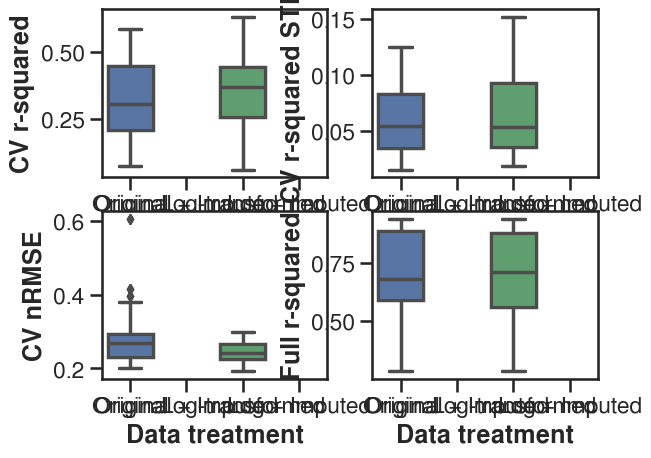

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()

models = ["Original", "Original + Imputed", "Log-transformed", "Log + Imputed"]
metrics = ["CV r-squared", "CV r-squared STD", "CV nRMSE", "Full r-squared"]

for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        ax = axs[i]
        sns.boxplot(x="Run type", y=metric, data=results, order=models, ax=ax)
        # data = results[results["Run ID"] == model][metric]
        # sns.boxplot(data=data, ax=ax)
        ax.set(xlabel="Data treatment", label=metric)
        ax.set_xlabel(ax.get_xlabel(), fontweight="bold")
        ax.set_ylabel(ax.get_ylabel(), fontweight="bold")

plt.show()

After dropping outlier models from the log-transformed suite of models, the log-transformed models appear to perform best in terms of CV R^2 and Overall R^2 and with a generally lower CV nRMSE, but greater variance in its CV R^2 standard deviation. This makes sense, as many of the untransformed traits were already normally distributed, and so log-transforming them would likley result in poorer model fitting.

In general, it appears that there is not a big difference between predictor datasets with missing values and imputed datasets, though the CV R^2 STD does increase slightly for models trained on non-imputed datasets.

**Now let's isolate the best performing models for each trait**

In [8]:
# First filter out rows that contain "imputed" in the Run ID column
results_mvs = results[~results["Run type"].str.contains("Imputed")]

# Only select rows with Run ID "2023-09-23_13-30-09" or "2023-09-23_11-44-08"
results_mvs = results_mvs[
    results_mvs["Run ID"].isin(["2023-09-23_13-30-09", "2023-09-23_11-44-08"])
]

# Next split results into GBIF and sPlot dataframes
results_gbif = results_mvs[results_mvs["Response variable"].str.contains("GBIF")]
results_splot = results_mvs[results_mvs["Response variable"].str.contains("sPlot")]

# Next create empty dataframes (one for GBIF and one for sPlot) with the same column names as the results dataframe
# Then, for each trait, get the row with the highest CV r-squared and append it to the empty dataframe
# This will give us the best model for each trait

best_models_gbif = pd.DataFrame(
    columns=results_gbif.columns.values,
    # index=range(len(mapping)),
)
best_models_splot = pd.DataFrame(
    columns=results_splot.columns.values,
    # index=range(len(mapping)),
)

for i, (trait_id, trait) in enumerate(mapping.items()):

    if int(trait_id) not in excluded_tidx:
        best_gbif_row = (
            results_gbif[results_gbif["Response variable"].str.contains(f"_X{trait_id}_")]
            .sort_values(by=["CV r-squared"], ascending=False)
            .iloc[0]
        )
        best_models_gbif = pd.concat([best_models_gbif, best_gbif_row.to_frame().T])

        # The best GBIF run types don't necessarily correspond to the best sPlot run types
        # for the same traits, but for an apples-to-apples comparison we should use the same
        # run types for both datasets
        best_gbif_trait = best_gbif_row["Response variable"].split("GBIF_")[1]

        best_splot_row = (
            results_splot[results_splot["Response variable"] == f"sPlot_{best_gbif_trait}"]
            .sort_values(by=["CV r-squared"], ascending=False)
            .iloc[0]
        )

        best_models_splot = pd.concat([best_models_splot, best_splot_row.to_frame().T])

best_models_gbif = best_models_gbif.sort_values(by=["CV r-squared"], ascending=False)
best_models_splot = best_models_splot.sort_values(by=["CV r-squared"], ascending=False)

In [9]:
def best_models_printable(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare the best models dataframe for printing in LaTeX"""
    df = df.drop(columns=["Run ID", "Response variable"])
    # Set numeric columns to float
    df = df.astype(
        {
            "N observations": int,
            "CV nRMSE": float,
            "CV nRMSE STD": float,
            "CV r-squared": float,
            "CV r-squared STD": float,
            "Full r-squared": float,
        }
    ).round(2)

    # append "(n = {N observations})" to Trait name values
    df["Trait name"] = (
        df["Trait name"].astype(str) + " (n=" + df["N observations"].astype(str) + ")"
    )

    # append "±{CV nRMSE STD}" to "CV nRMSE" values (do the same for CV r-squared)
    df["CV nRMSE"] = df["CV nRMSE"].astype(str) + " ±" + df["CV nRMSE STD"].astype(str)
    df["CV r-squared"] = (
        df["CV r-squared"].astype(str) + " ±" + df["CV r-squared STD"].astype(str)
    )

    df = df.drop(columns=["N observations", "CV nRMSE STD", "CV r-squared STD"])

    return df

In [10]:
print(best_models_printable(best_models_gbif).to_markdown(index=False, floatfmt=".2f"))

| Run type        | Trait name                        | CV nRMSE   | CV r-squared   |   Full r-squared |
|:----------------|:----------------------------------|:-----------|:---------------|-----------------:|
| Log-transformed | Stem conduit density (n=33043)    | 0.21 ±0.01 | 0.53 ±0.03     |             0.73 |
| Log-transformed | Seed mass (n=33155)               | 0.23 ±0.01 | 0.45 ±0.02     |             0.69 |
| Original        | Leaf delta 15N (n=35116)          | 0.24 ±0.01 | 0.45 ±0.04     |             0.69 |
| Log-transformed | RRD (n=33163)                     | 0.24 ±0.01 | 0.44 ±0.04     |             0.69 |
| Log-transformed | Leaf fresh mass (n=33195)         | 0.24 ±0.01 | 0.37 ±0.03     |             0.65 |
| Log-transformed | Seed length (n=33176)             | 0.24 ±0.02 | 0.37 ±0.05     |             0.65 |
| Log-transformed | Leaf dry mass (n=33162)           | 0.24 ±0.01 | 0.36 ±0.05     |             0.63 |
| Log-transformed | Plant height (n=33135)            |

In [11]:
print(best_models_printable(best_models_splot).to_markdown(index=False, floatfmt=".2f"))

| Run type        | Trait name                       | CV nRMSE   | CV r-squared   |   Full r-squared |
|:----------------|:---------------------------------|:-----------|:---------------|-----------------:|
| Log-transformed | RRD (n=4985)                     | 0.19 ±0.02 | 0.63 ±0.07     |             0.94 |
| Original        | SSD (n=5307)                     | 0.2 ±0.01  | 0.58 ±0.06     |             0.93 |
| Log-transformed | Stem conduit density (n=5009)    | 0.2 ±0.02  | 0.57 ±0.08     |             0.88 |
| Original        | SLA (n=5322)                     | 0.21 ±0.02 | 0.53 ±0.09     |             0.91 |
| Log-transformed | Leaf N (area) (n=4958)           | 0.21 ±0.01 | 0.52 ±0.1      |             0.93 |
| Log-transformed | Leaf area (n=5008)               | 0.2 ±0.02  | 0.51 ±0.1      |             0.87 |
| Original        | Leaf delta 15N (n=5356)          | 0.21 ±0.01 | 0.49 ±0.08     |             0.90 |
| Log-transformed | Leaf fresh mass (n=4999)         | 0.21 ±0.0

Figure with scatterplots of CV-predictions vs observed for each of a subset of traits, along with R

In [12]:
from utils.geodata import get_trait_id_from_data_name


def get_cv_run_dirs(gbif_id_rvs, splot_id_rvs, select_traits=None):
    results_dir = Path("results/training")
    gbif_trait_dirs = [Path(results_dir / run_id / f"{rv}") for run_id, rv in gbif_id_rvs]
    splot_trait_dirs = [Path(results_dir / run_id / f"{rv}") for run_id, rv in splot_id_rvs]
    
    gbif_cv_dirs = []
    splot_cv_dirs = []
    
    for trait_dir in gbif_trait_dirs:
        trait_id = get_trait_id_from_data_name(trait_dir.name)
        if select_traits is not None:
            if int(trait_id) in select_traits:
                gbif_cv_dirs.append(trait_dir)
        else:
            gbif_cv_dirs.append(trait_dir)

    for trait_dir in splot_trait_dirs:
        trait_id = get_trait_id_from_data_name(trait_dir.name)
        if select_traits is not None:
            if int(trait_id) in select_traits:
                splot_cv_dirs.append(trait_dir)
        else:
            splot_cv_dirs.append(trait_dir)

    return gbif_cv_dirs, splot_cv_dirs

In [13]:
from typing import Any, Optional, Tuple


def plot_observed_vs_predicted(
    ax: plt.Axes,
    observed: pd.Series,
    predicted: pd.Series,
    name: str,
    log: bool = False,
    density: bool = False,
    show_r: bool = True,
    context: Any = "talk",
    font_scale: float = 1,
):
    """Plot observed vs. predicted values."""

    p1 = min(predicted.min(), observed.min())
    p2 = max(predicted.max(), observed.max())

    cmap = sns.cubehelix_palette(start=0.5, rot=-0.75, reverse=True, as_cmap=True)  # type: ignore
    if density:
        plot = sns.kdeplot(x=predicted, y=observed, ax=ax, cmap=cmap, fill=True, thresh=0.0075)
    else:
        plot = sns.scatterplot(x=predicted, y=observed, ax=ax, s=1)
    
    plot.set(xlabel=None, ylabel=None)

    # Fit a regression line for observed vs. predicted values, plot the regression
    # line so that it spans the entire plot, and print the correlation coefficient
    m, b = np.polyfit(predicted, observed, 1)
    reg_line = [m * p1 + b, m * p2 + b]

    midline_params = {
        "color": "black",
        "ls": "-.",
        "lw": 0.5,
        "alpha": 0.5,
    }

    regline_params = {"color": "red", "lw": 0.5}
    if log:
        ax.loglog([p1, p2], [p1, p2], **midline_params)
        ax.loglog([p1, p2], reg_line, **regline_params)
    else:
        ax.plot([p1, p2], [p1, p2], **midline_params)
        ax.plot([p1, p2], reg_line, **regline_params)

    # make sure lines are positioned on top of kdeplot
    ax.set_zorder(1)

    buffer_color = "white"

    text_params = {
        "transform": ax.transAxes,
        "ha": "left",
        "va": "top",
        "bbox": {"facecolor": buffer_color, "edgecolor": buffer_color, "pad": 0.5},
    }

    if show_r:
        ax.text(
            0.05,
            0.95,
            f"$r$ = {np.corrcoef(predicted, observed)[0, 1]:.3f}",
            **text_params,
        )

    ax.text(0.05, 0.95 - (0.05 * font_scale), f"n = {len(predicted):,}", **text_params)

    # include legend items for the reg_line and the 1-to-1 line
    ax.legend(
        [
            ax.get_lines()[0],
            ax.get_lines()[1],
        ],
        ["1-to-1", "Regression"],
        loc="lower right",
        frameon=False,
        fontsize=14
    )

    # set informative axes and title
    # ax.set_xlabel("Predicted")
    # ax.set_ylabel("Observed")
    ax.set_title(name, weight="bold")

    return ax


import matplotlib.gridspec as gridspec


def subplots_centered(nrows, ncols, figsize, nfigs):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.

    It returns a grid where the plots
    in the **last** row are centered.

    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    if not nfigs < nrows * ncols:
        print("No empty subplots, using normal plt.subplots() instead")
        fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
        return fig, ax

    fig = plt.figure(figsize=figsize)
    axs = []

    m = nfigs % ncols
    m = range(1, ncols + 1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m * ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows - 1:  # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off : m * (col + 1) + off])
        axs.append(ax)

    return fig, np.asarray(axs)


def plot_all_trait_obs_pred(
    trait_dirs,
    mapping=None,
    ncols: int = 5,
    density: bool = False,
    context: Any = "paper",
    font_scale: float = 1,
    out_fn: Optional[str] = None
):
    """Plot observed vs. predicted values for all traits in the given list of trait directories."""
    ntraits = len(trait_dirs)
    nrows = int(np.ceil(ntraits / ncols))

    with sns.plotting_context(context, font_scale):
        fig, axs = subplots_centered(
            nrows=nrows, ncols=ncols, figsize=(5.5 * ncols, 5 * nrows), nfigs=ntraits
        )
        # fig, axs = plt.subplots(
        #     nrows=nrows,
        #     ncols=ncols,
        #     figsize=(20, 5 * nrows),
        #     tight_layout=True,
        #     # dpi=200,
        # )

        axs = axs.flatten()

        for i, trait_dir in enumerate(trait_dirs):
            trait = trait_dir.stem

            log = trait.endswith("_ln")

            if mapping:
                # Update trait name to match the mapping
                trait_id = trait.split("_X")[1].split("_")[0]
                # trait_set = trait.split("_")[0]
                trait = mapping[trait_id]['short']
                if "(3113)" in trait:
                    trait = trait.replace(" (3113)", "")
                if log:
                    trait += " (log)"

            obs_vs_pred = pd.read_parquet(trait_dir / "cv_predictions.parq")

            obs = obs_vs_pred["observed"]
            pred = obs_vs_pred["predicted"]

            axs[i] = plot_observed_vs_predicted(
                axs[i],
                obs,
                pred,
                trait,
                density=density,
                show_r=False,
                context=context,
                font_scale=font_scale,
            )

            # Plot CV R with STD instead of simple r
            r_mean, r_std = cv_r(obs_vs_pred)
            axs[i].text(
                0.05,
                0.95,
                f"$r$ = {r_mean:.2f}±{r_std:.2f}",
                transform=axs[i].transAxes,
                ha="left",
                va="top",
                bbox={"facecolor": "white", "edgecolor": "white", "pad": 0.5},
            )
        
        # Add "Observed" in vertical alignment to left center side of figure, "Predicted" in horizontal alignment to bottom center of figure
        fig.text(
            -0.02,
            0.5,
            "Observed",
            va="center",
            rotation="vertical",
            fontweight="bold",
            fontsize="large",
        )
        fig.text(
            0.5,
            -0.02,
            "Predicted",
            ha="center",
            fontweight="bold",
            fontsize="large",
        )

        # Ensure that only the left-most column has y-axis labels
        # for i in range(ntraits):
        #     if i % ncols != 0:
        #         axs[i].set_ylabel("")

        fig.set_tight_layout(True)
        sns.despine()

        if out_fn is not None:
            plt.savefig(out_fn, bbox_inches="tight")


def cv_r(df: pd.DataFrame) -> Tuple[float, float]:
    """Calculate the mean and standard deviation of the correlation coefficient for each
    fold in the given dataframe"""
    grouped = df.groupby("fold").apply(lambda x: x["observed"].corr(x["predicted"]))
    return (grouped.mean(), grouped.std())

In [14]:
# Create a list of tuples of Run ID and Response variable for each row in best_models_gbif and best_models_splot
# This will be used to filter out the results dataframes to only include the best model for each trait
best_models_gbif = best_models_gbif.sort_values(by="Trait name", ascending=True)
best_models_splot = best_models_splot.sort_values(by="Trait name", ascending=True)

gbif_id_rvs = list(
    zip(best_models_gbif["Run ID"], best_models_gbif["Response variable"])
)
splot_id_rvs = list(
    zip(best_models_splot["Run ID"], best_models_splot["Response variable"])
)

# select_traits = [169, 4, 50, 14, 11, 6]
# select_traits = [4]
select_traits = None

gbif_cv_dirs, splot_cv_dirs = get_cv_run_dirs(gbif_id_rvs, splot_id_rvs, select_traits)

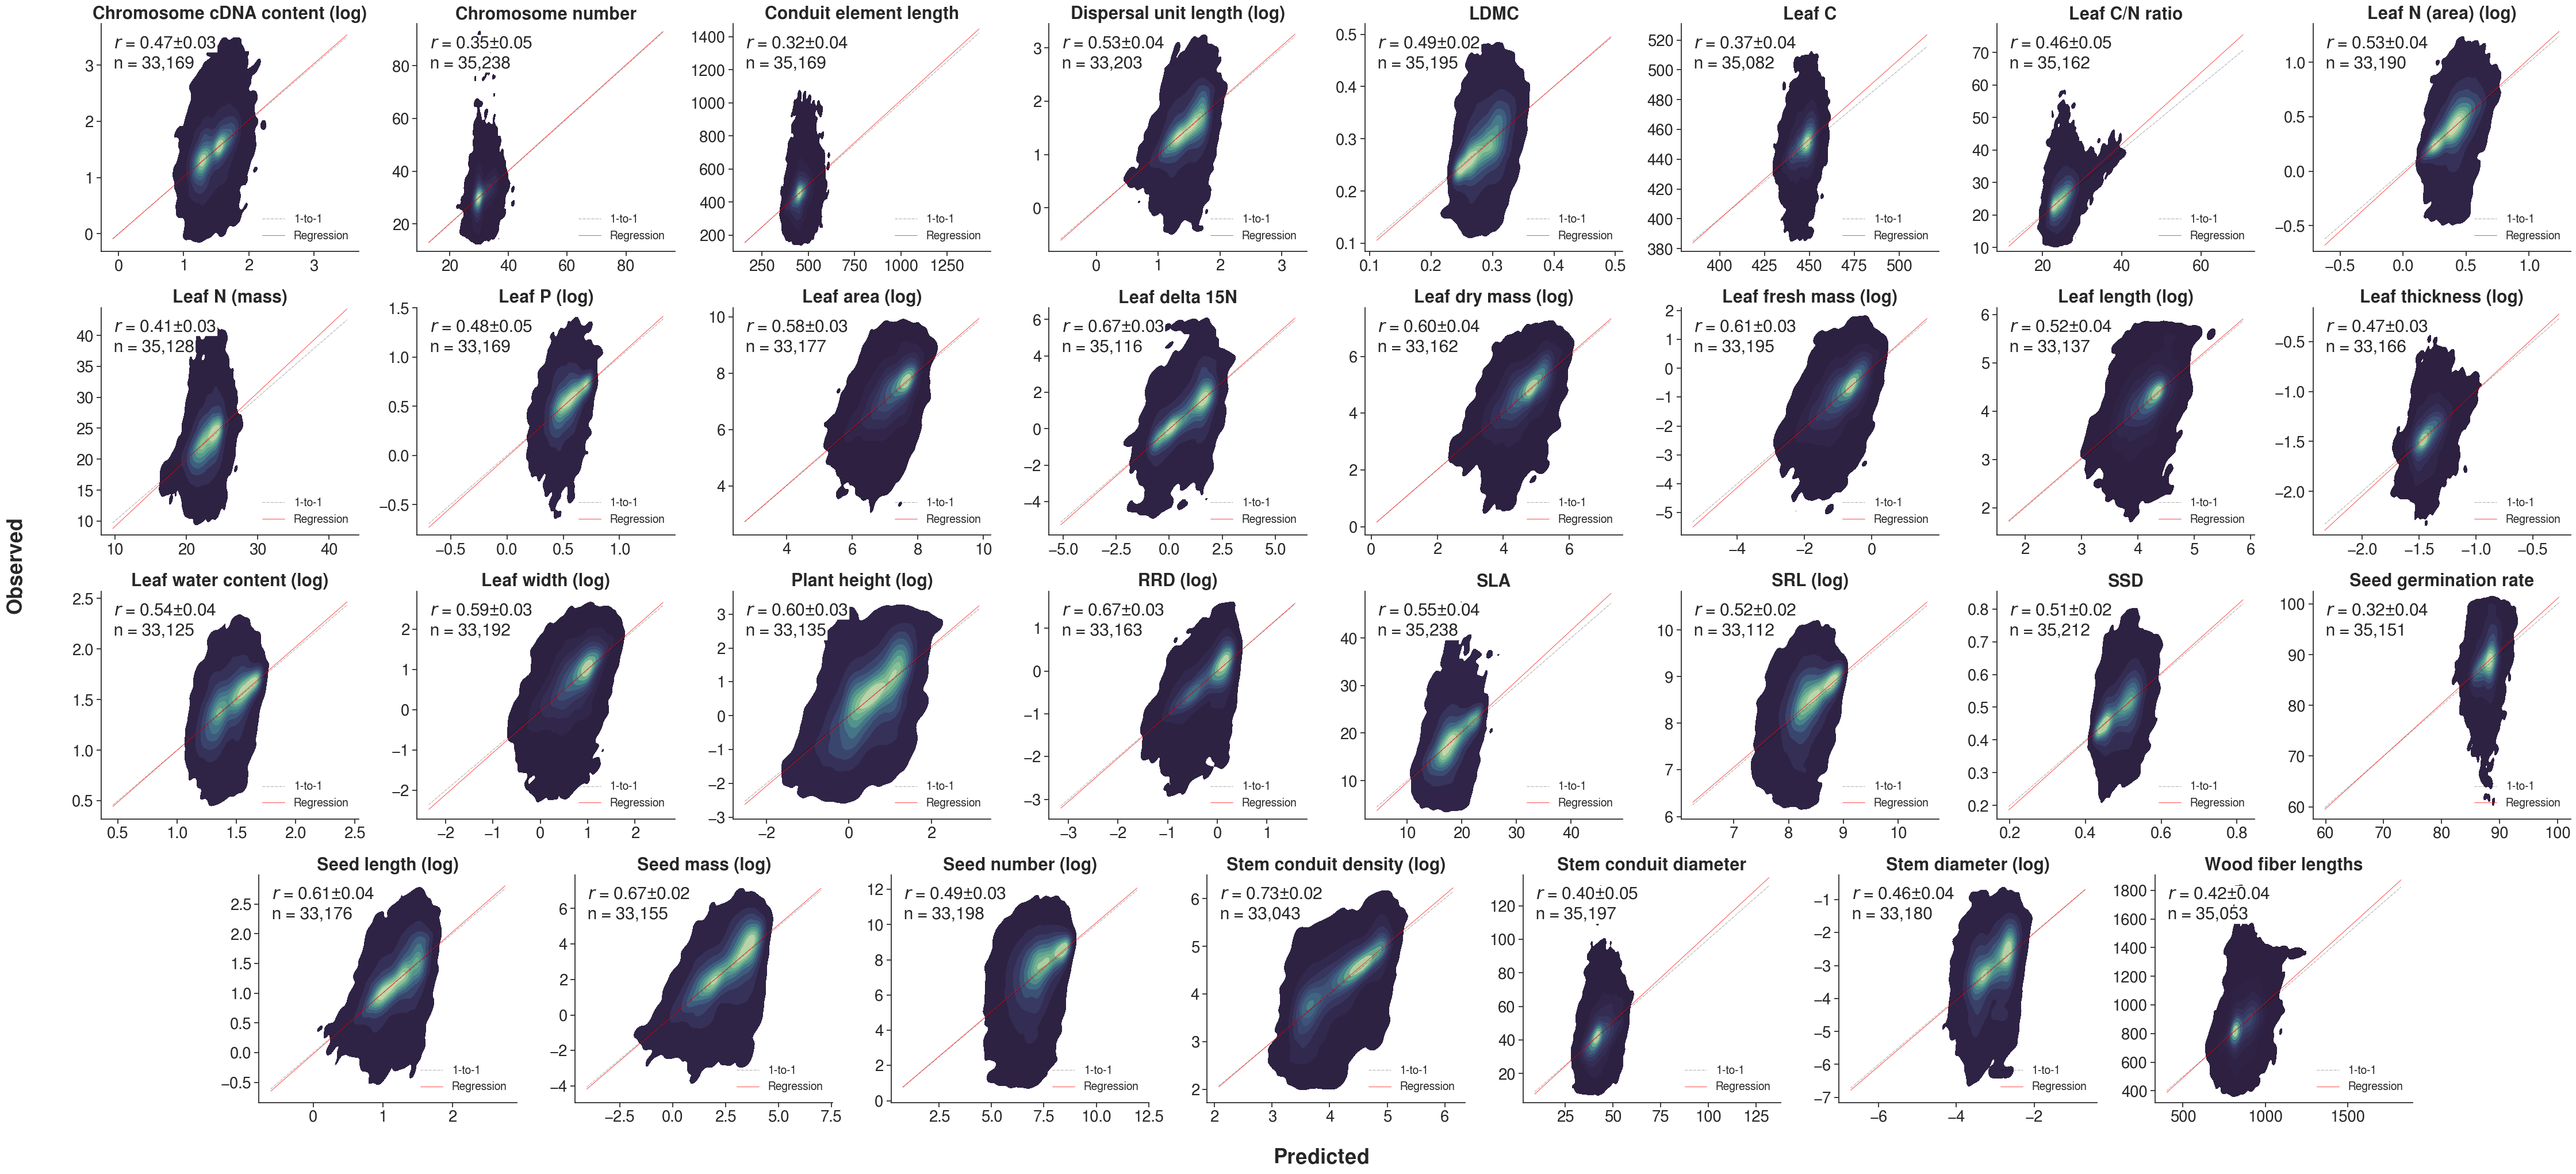

In [17]:
# plot_all_trait_obs_pred(gbif_trait_dirs, mapping, density=True, context="notebook")
plot_all_trait_obs_pred(
    gbif_cv_dirs,
    mapping,
    ncols=8,
    density=True,
    context="notebook",
    font_scale=1.8,
    out_fn="reports/figures/gbif-obs-vs-pred_density_7col.png",
)

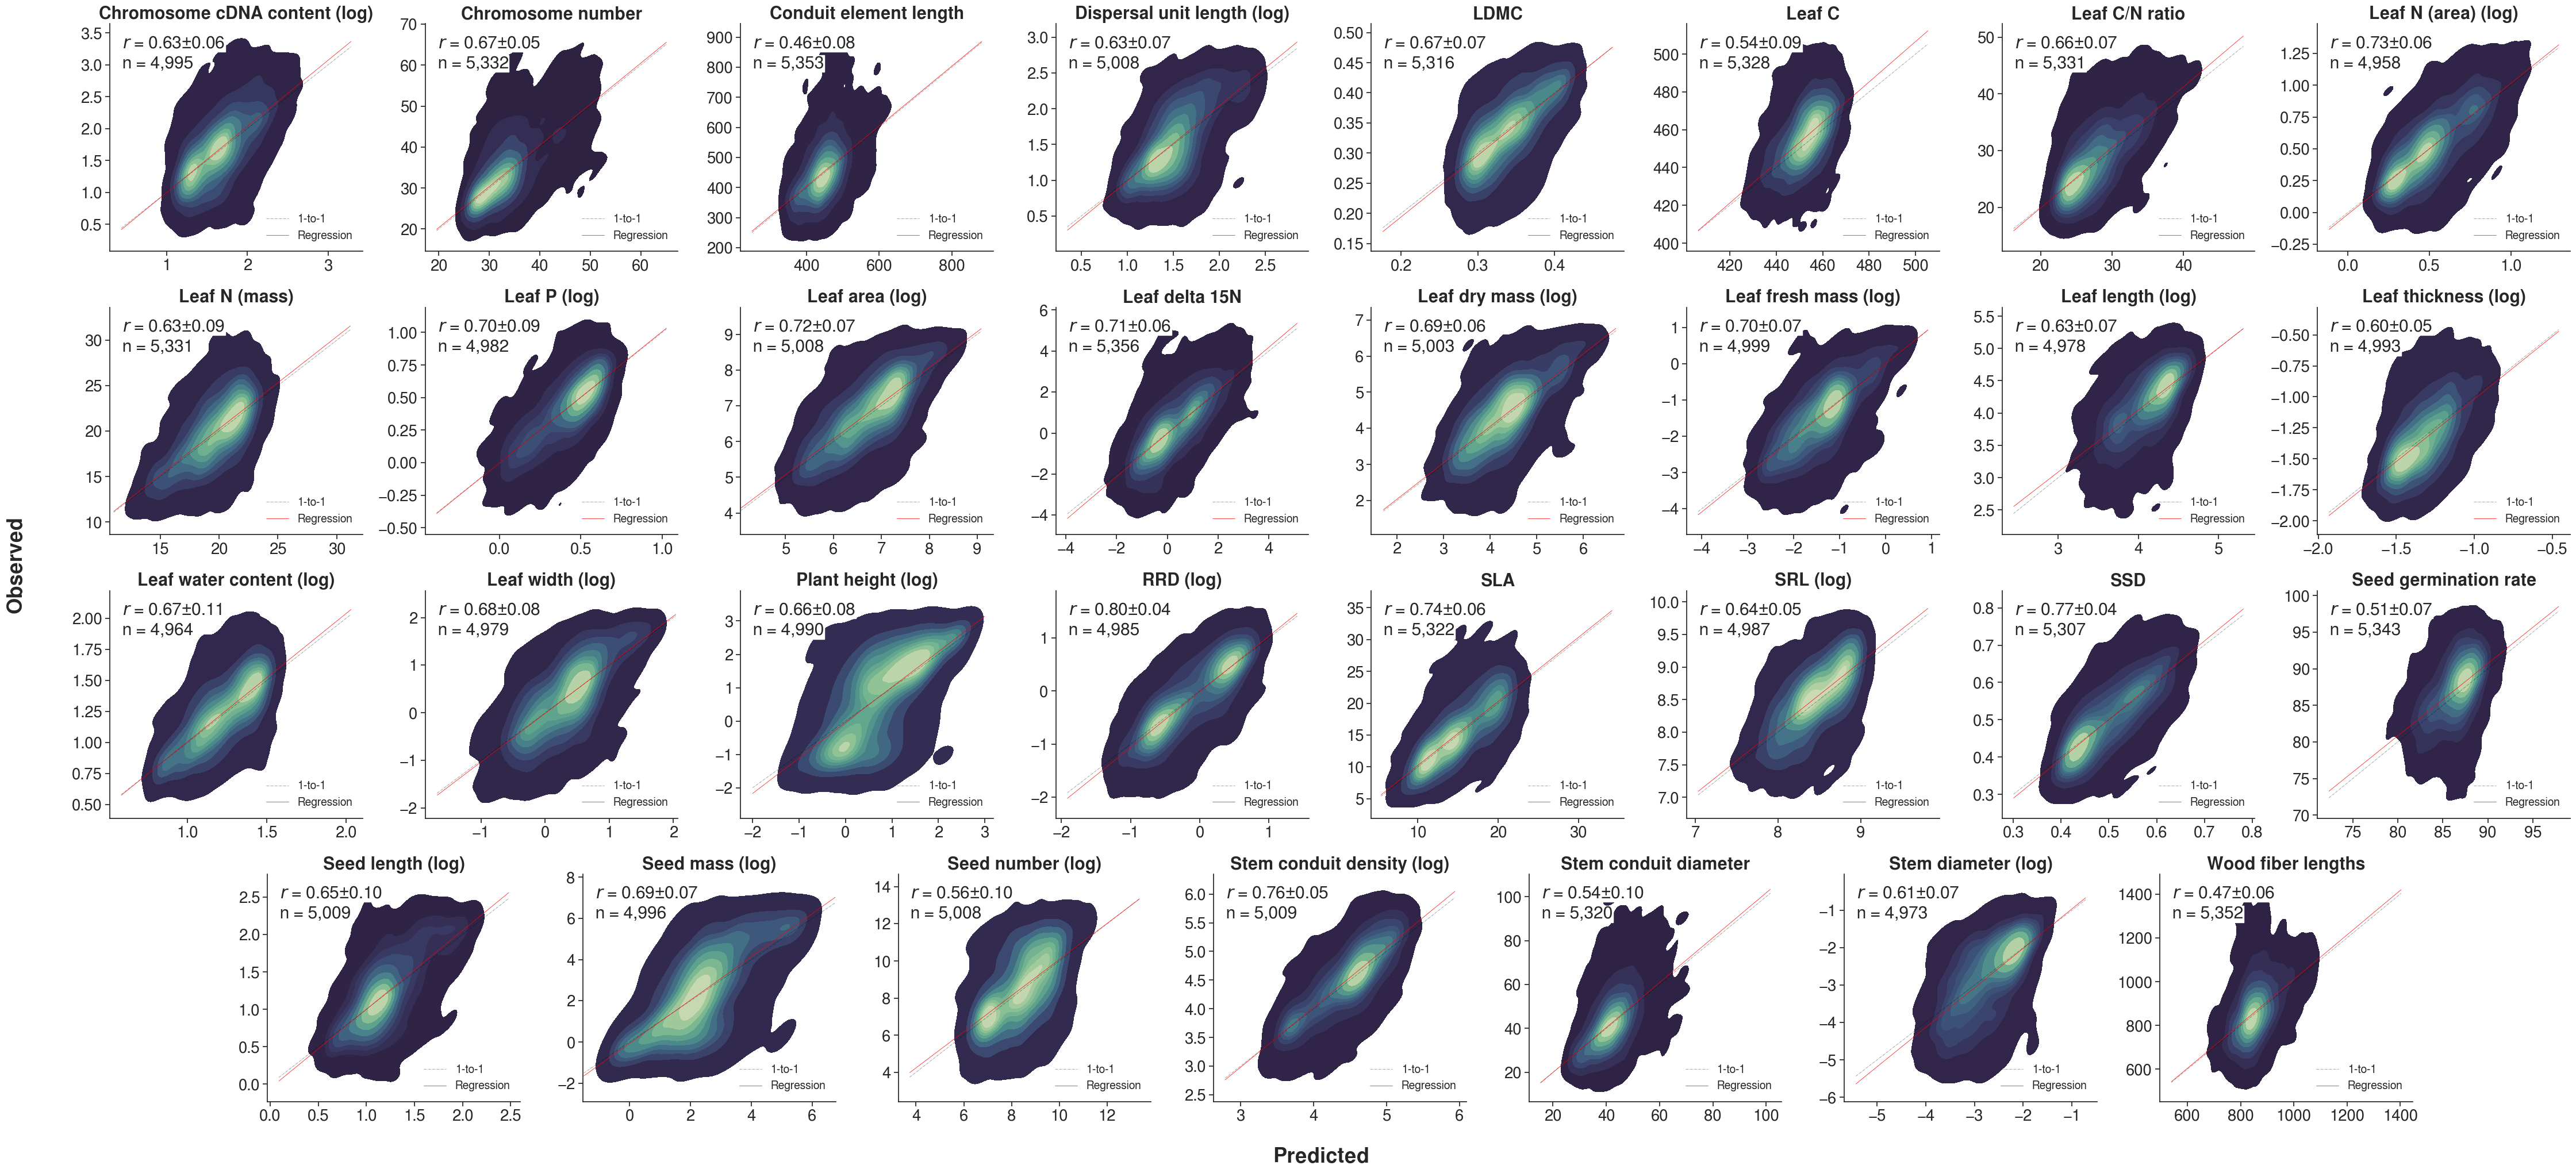

In [15]:
# plot_all_trait_obs_pred(splot_trait_dirs, mapping, density=True, context="notebook")
plot_all_trait_obs_pred(splot_cv_dirs, mapping, ncols=8, density=True, context="notebook", font_scale=1.8, out_fn="reports/figures/splot-obs-vs-pred_density_8col.png")

## Crowd-sourced vs sPlotOpen

Figure: Box plot of GBIF and sPlot CV-R2 (y-axis) for each trait (x-axis). I.e. two boxes for each trait, one for GBIF and one for sPlot. Could print RMSE ± STD for each one, too?

Bar chart

In [14]:
def plot_gbif_splot_model_stats(
    gbif_models,
    splot_models,
    stat="CV r-squared",
    out_fn=None,
    context="paper",
    aspect=15,
    x_label_pad=0.55,
):
    # Then, merge the two dataframes on Response variable
    best_models_gbif_splot = pd.merge(
        gbif_models,
        splot_models,
        on="Response variable",
        suffixes=("_gbif", "_splot"),
    )

    x_labels = best_models_gbif_splot["Trait name_gbif"]
    bar_width = 0.35
    x_pos = [i for i in range(len(x_labels))]

    # plot the GBIF CV r-squared values as bars
    gbif_stat = best_models_gbif_splot[f"{stat}_gbif"]
    gbif_std = best_models_gbif_splot[f"{stat} STD_gbif"]

    # plot the sPlot CV r-squared values as bars
    splot_stat = best_models_gbif_splot[f"{stat}_splot"]
    splot_std = best_models_gbif_splot[f"{stat} STD_splot"]

    with sns.plotting_context(context, font_scale=1.7):
        plt.bar(x_pos, gbif_stat, width=bar_width, yerr=gbif_std, label="GBIF")
        plt.bar(
            [i + bar_width for i in x_pos],
            splot_stat,
            width=bar_width,
            yerr=splot_std,
            label="sPlot",
        )

        # set the x-axis labels and title
        plt.xlabel("Response variable", weight="bold")
        if stat == "CV r-squared":
            plt.ylabel("CV R$^2$", weight="bold")
        else:
            plt.ylabel("CV nRMSE", weight="bold")

        sns.despine()
        ax = plt.gca()
        ax.set_aspect(aspect)

        fig = plt.gcf()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        fig.set_dpi(300)

        ax = plt.gca()
        # ax.xaxis.set_label_coords(0.486, -0.5)
        ax.xaxis.set_label_coords(0.5, -x_label_pad)

        # set the x-axis tick positions and labels
        plt.xticks([i + bar_width / 2 for i in x_pos], x_labels, rotation=90)
        plt.legend(edgecolor="white")
        if out_fn is not None:
            plt.savefig(fig_dir / out_fn, bbox_inches="tight")
        plt.show()

Violin plot

In [28]:
def plot_gbif_splot_model_stats_violin(
    gbif_models,
    splot_models,
    stat="CV r-squared",
    out_fn=None,
    context="paper",
    aspect=15,
    x_label_pad=0.55,
):
    # Then, merge the two dataframes on Response variable
    best_models_gbif_splot = pd.merge(
        gbif_models,
        splot_models,
        on="Response variable",
        suffixes=("_gbif", "_splot"),
    )

    x_labels = best_models_gbif_splot["Trait name_gbif"]
    bar_width = 0.35
    x_pos = [i for i in range(len(x_labels))]

    # plot the GBIF CV r-squared values as bars
    gbif_stat = best_models_gbif_splot[f"{stat}_gbif"]
    gbif_std = best_models_gbif_splot[f"{stat} STD_gbif"]

    # plot the sPlot CV r-squared values as bars
    splot_stat = best_models_gbif_splot[f"{stat}_splot"]
    splot_std = best_models_gbif_splot[f"{stat} STD_splot"]

    with sns.plotting_context(context, font_scale=1.7):
        # plt.bar(x_pos, gbif_stat, width=bar_width, yerr=gbif_std, label="GBIF")
        # plt.bar(
        #     [i + bar_width for i in x_pos],
        #     splot_stat,
        #     width=bar_width,
        #     yerr=splot_std,
        #     label="sPlot",
        # )

        # plot a violin plot with all gbif_stat values on the left, and splot on the right
        ax = sns.violinplot([gbif_stat, splot_stat])
        # sns.violinplot(splot_stat, ax=ax)

        # set the x-axis labels and title
        plt.xlabel("Trait set", weight="bold")
        if stat == "CV r-squared":
            plt.ylabel("CV R$^2$", weight="bold")
        else:
            plt.ylabel("CV nRMSE", weight="bold")

        sns.despine()
        # ax = plt.gca()
        # ax.set_aspect(aspect)

        fig = plt.gcf()
        # fig.set_figheight(15)
        # fig.set_figwidth(15)
        fig.set_dpi(300)

        # ax = plt.gca()
        # # ax.xaxis.set_label_coords(0.486, -0.5)
        # ax.xaxis.set_label_coords(0.5, -x_label_pad)

        # set the x-axis tick positions and labels
        plt.xticks([0, 1], ["GBIF", "sPlot"])
        # plt.legend(edgecolor="white")
        # if out_fn is not None:
        #     plt.savefig(fig_dir / out_fn, bbox_inches="tight")
        plt.show()

In [17]:
best_models_gbif = best_models_gbif.sort_values(by=["CV r-squared"], ascending=False)
best_models_splot = best_models_splot.sort_values(by=["CV r-squared"], ascending=False)

# For each matching Response variable in best_models_gbif and best_models_splot, plot
# the CV r-squared values as a bar chart, with the corresponding CV r-squared STD representing the error bars

# First, drop the GBIF_ and sPlot_ prefixes from the Response variable column
best_models_gbif["Response variable"] = best_models_gbif[
    "Response variable"
].str.replace("GBIF_", "")
best_models_splot["Response variable"] = best_models_splot[
    "Response variable"
].str.replace("sPlot_", "")

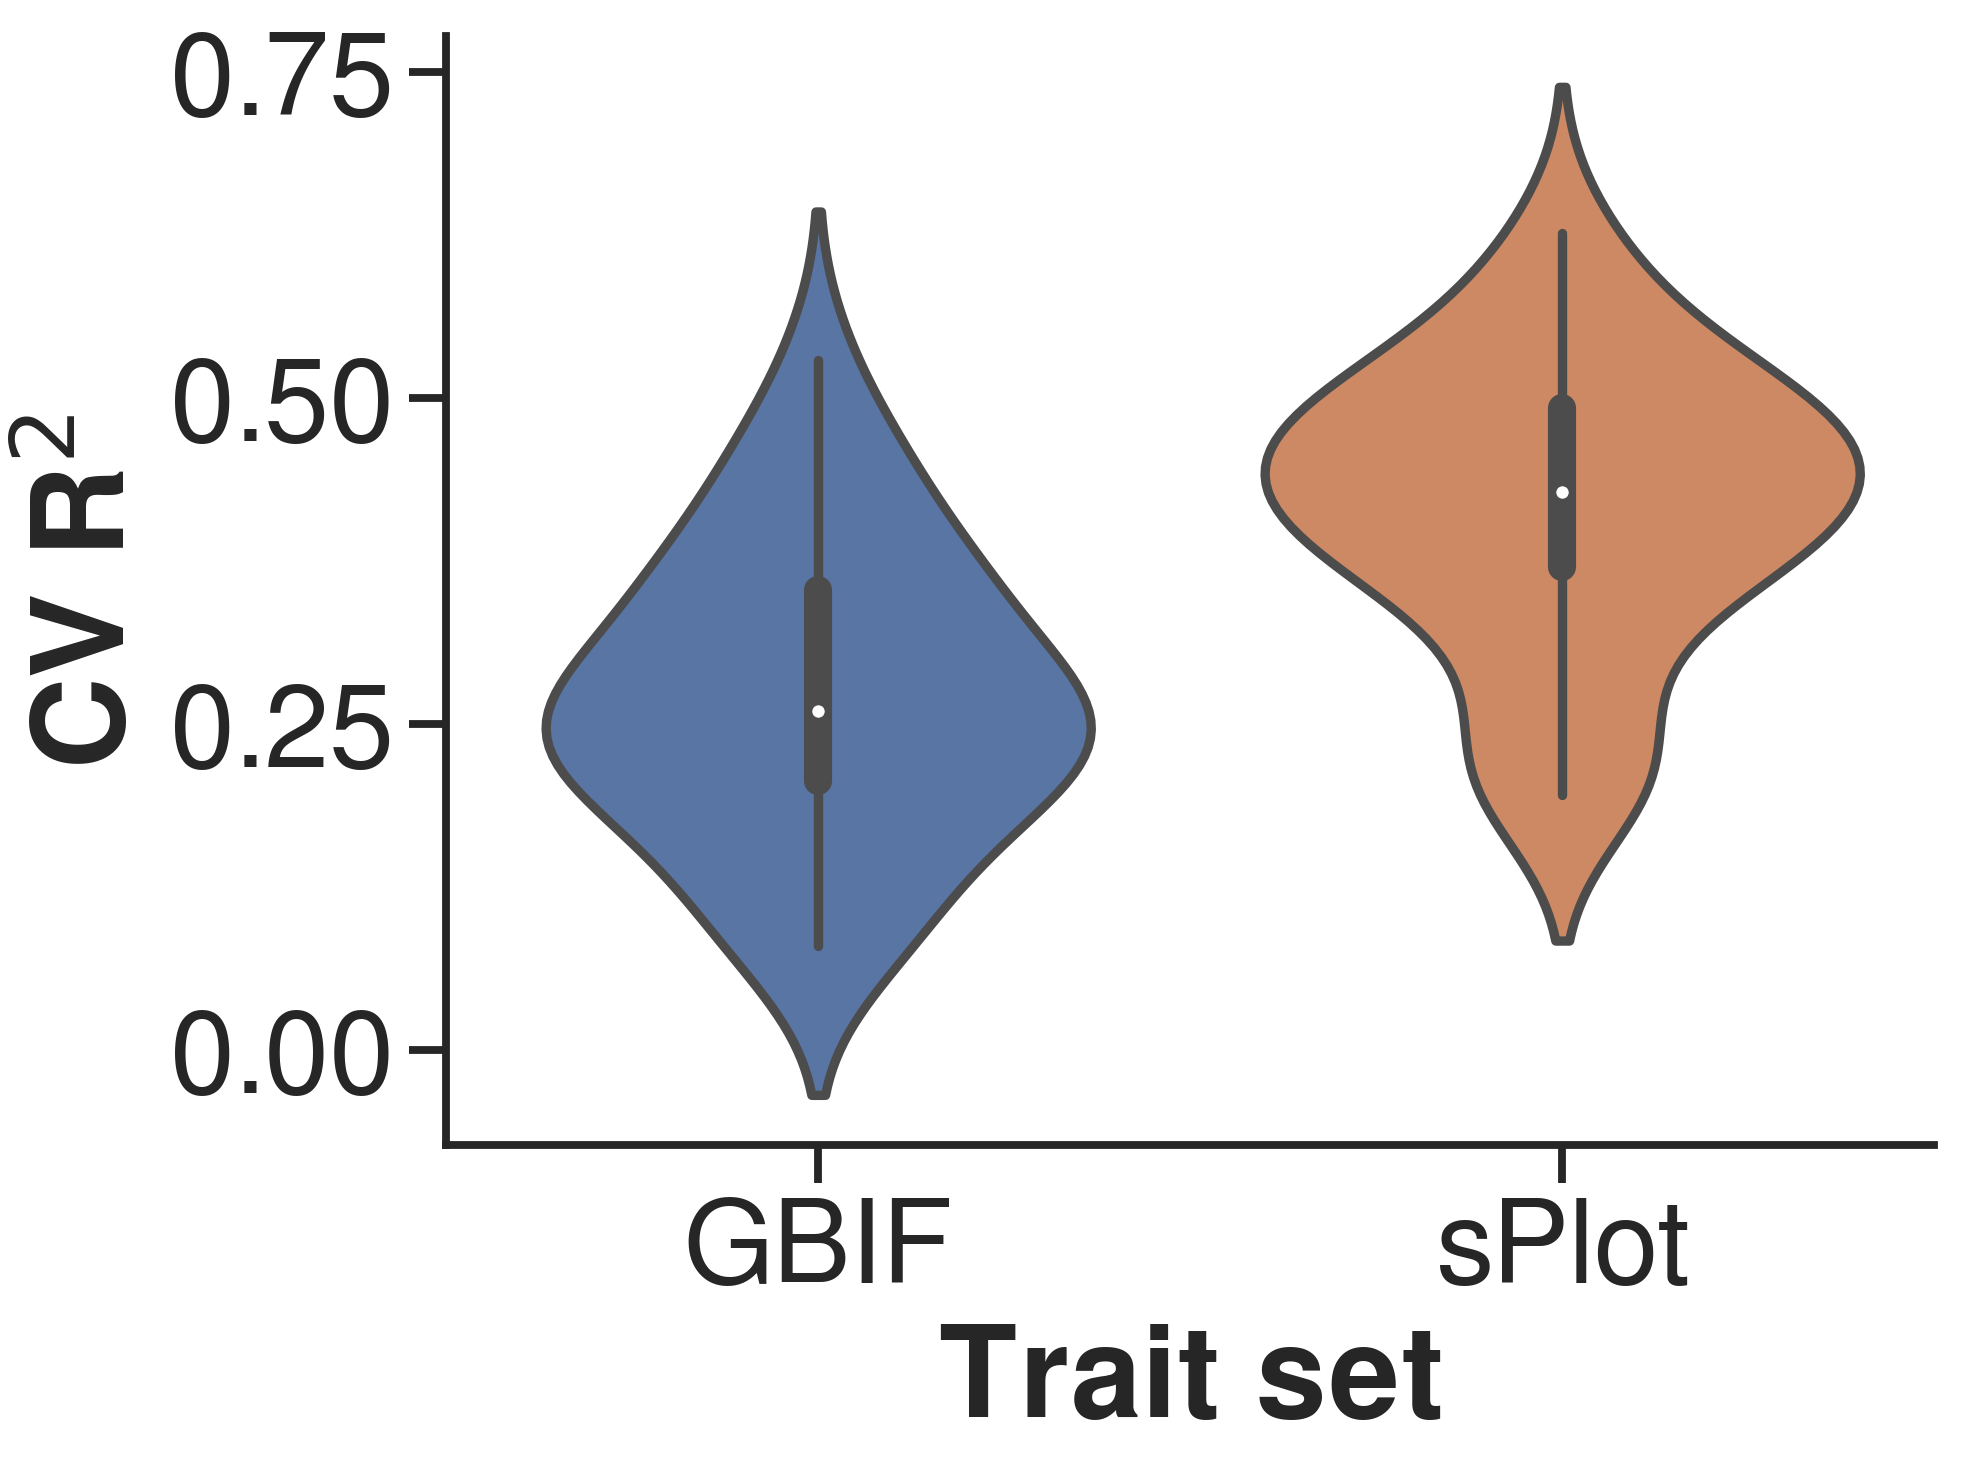

In [29]:
plot_gbif_splot_model_stats_violin(best_models_gbif, best_models_splot, context="talk")

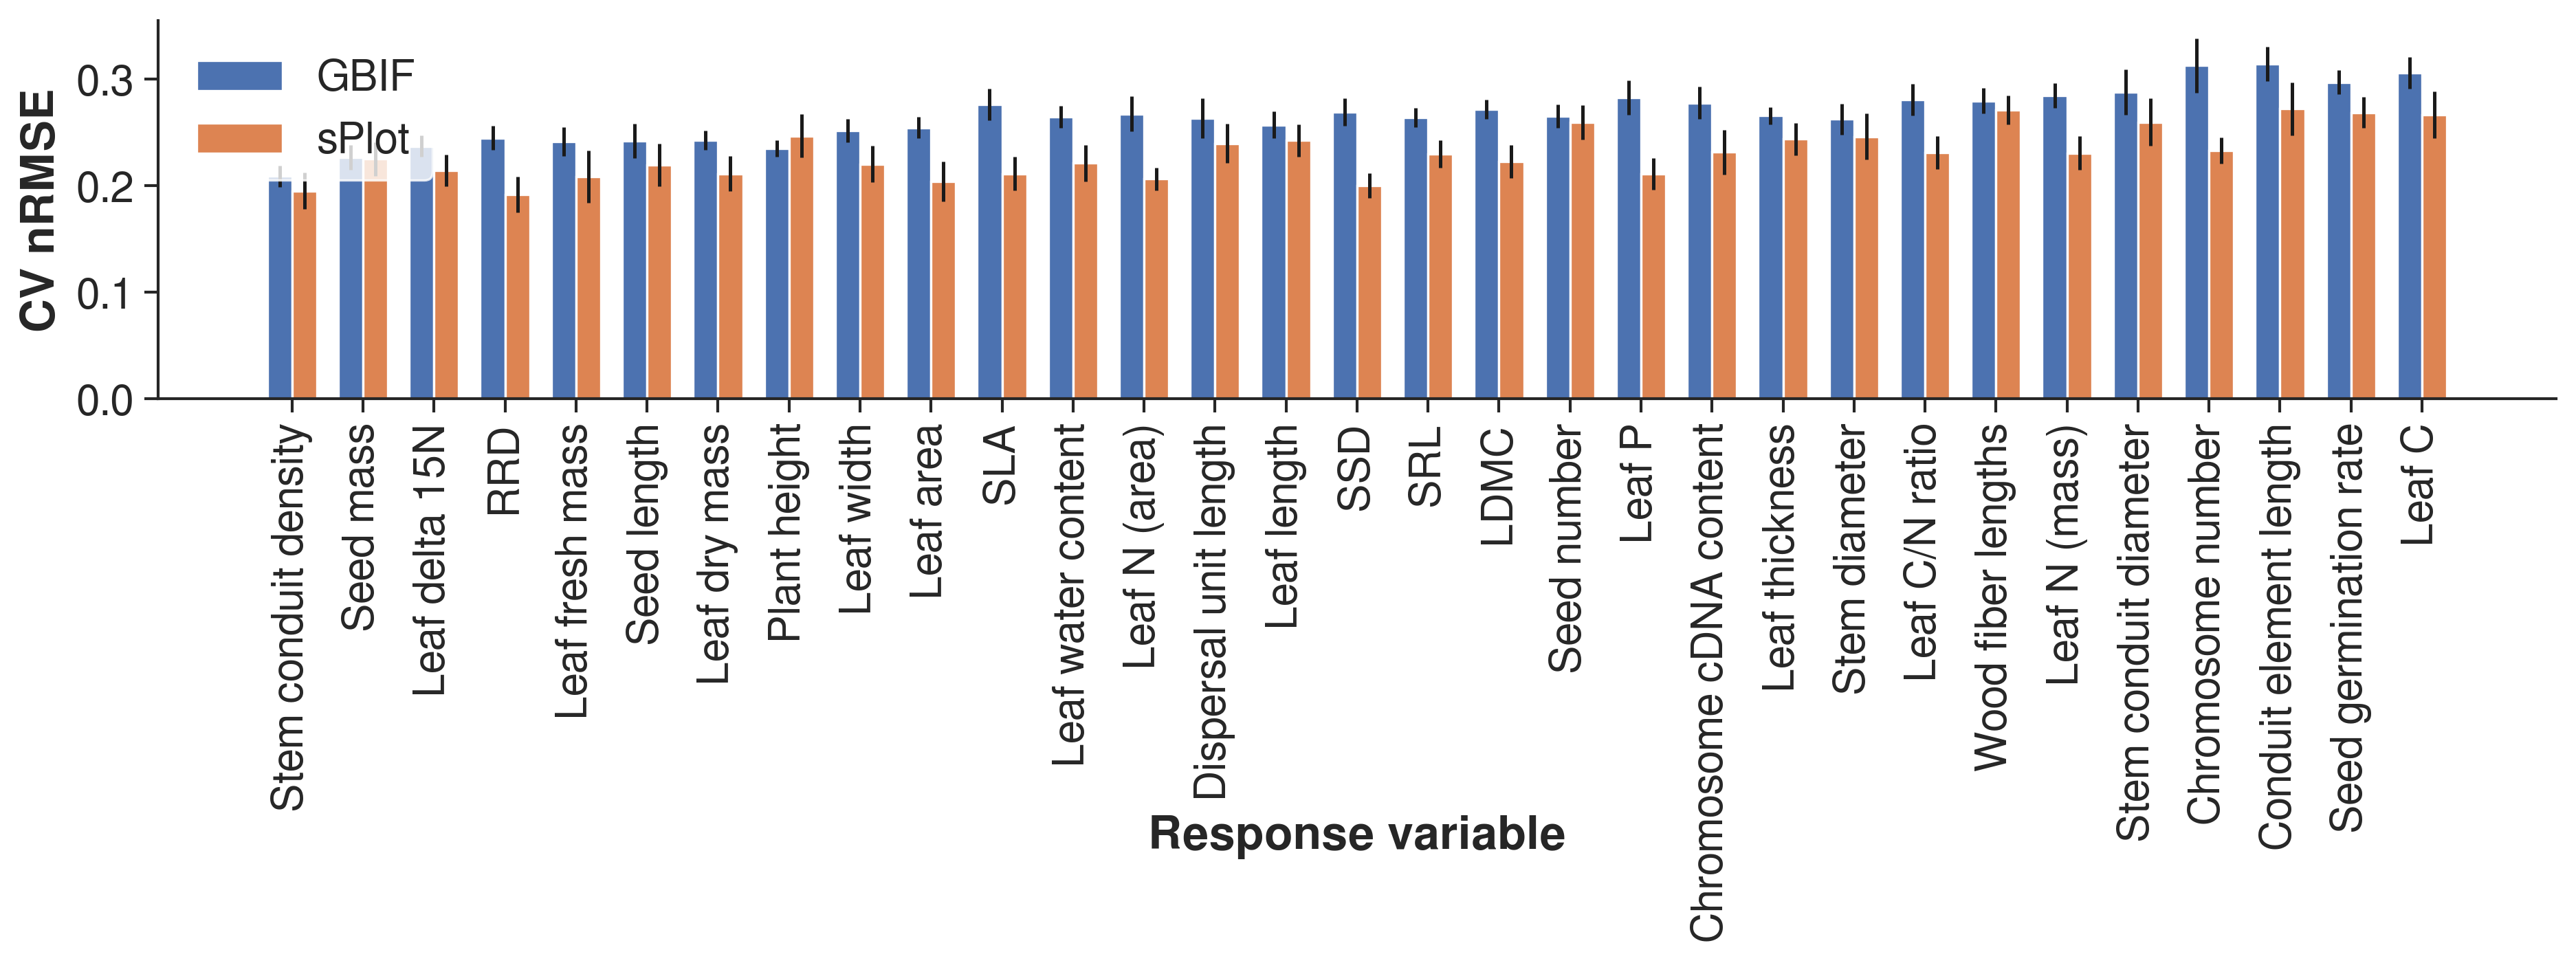

In [116]:
plot_gbif_splot_model_stats(best_models_gbif, best_models_splot, stat="CV nRMSE", aspect=15, x_label_pad=1.1)

Table (or bar chart) showing global cover % for GBIF vs sPlotOpen traits (should include CV R2 for each model, too, since GBIF generally has lower R2.

In [15]:
from typing import Union
from pathlib import Path

import dask.dataframe as dd
import pandas as pd
from utils.geodata import get_trait_id_from_data_name, get_trait_name_from_data_name
from tqdm.notebook import tqdm


# predict_name = "MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_0.5_deg_nan-strat=any_thr=0.5"


def single_res_aoa_table(
    resolution: Union[int, float] = 0.5,
    pft: str = "Shrub_Tree_Grass",
) -> pd.DataFrame:
    """Create a table of AOA values for each trait at a given resolution and PFT"""
    use_dask = False

    if resolution == 0.01:
        predict_name = "tiled_5x5_deg_MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_0.01_deg_nan-strat=any_thr=0.5"
        use_dask = True
    else:
        predict_name = f"MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_{resolution:g}_deg_nan-strat=any_thr=0.5"

    predicted_traits = list(
        Path(f"results/predictions/05deg_models/{predict_name}/{pft}").glob("*")
    )

    aoa_df = pd.DataFrame(
        columns=["GBIF AOA", "sPlot AOA", "Pct change"],
    )

    for trait in tqdm(predicted_traits):
        if not trait.is_dir():
            continue
        tid = get_trait_id_from_data_name(trait.name)
        if tid is not None and int(tid) in excluded_tidx:
            continue
        gbif_fn = list(Path(trait, "GBIF").glob("*.parq"))[0]
        splot_fn = list(Path(trait, "sPlot").glob("*.parq"))[0]

        if use_dask:
            columns = dd.read_parquet(gbif_fn).columns.values
            if "AOA" not in columns:
                continue
            else:
                gbif_trait_df = dd.read_parquet(gbif_fn, columns=["AOA"])
                splot_trait_df = dd.read_parquet(splot_fn, columns=["AOA"])
        else:
            columns = pd.read_parquet(gbif_fn).columns.values
            if "AOA" not in columns:
                continue
            else:
                gbif_trait_df = pd.read_parquet(gbif_fn, columns=["AOA"])
                splot_trait_df = pd.read_parquet(splot_fn, columns=["AOA"])

        # For each trait, add a new row to aoa_df with the response variable, GBIF AOA, and sPlot AOA

        gbif_aoa = gbif_trait_df["AOA"].sum() / gbif_trait_df["AOA"].count()
        splot_aoa = splot_trait_df["AOA"].sum() / splot_trait_df["AOA"].count()

        gbif_aoa = gbif_aoa.compute() if use_dask else gbif_aoa
        splot_aoa = splot_aoa.compute() if use_dask else splot_aoa

        new_row = [gbif_aoa * 100, splot_aoa * 100, (gbif_aoa - splot_aoa) * 100]

        trait_name = get_trait_name_from_data_name(trait.name, short=True)
        aoa_df.loc[trait_name] = new_row

    aoa_df = aoa_df.dropna().astype(float).sort_values(by="Pct change", ascending=False)

    return aoa_df


aoa_05 = single_res_aoa_table(resolution=0.5)
aoa_2 = single_res_aoa_table(resolution=2)
aoa_02 = single_res_aoa_table(resolution=0.2)
# aoa_001 = single_res_aoa_table(resolution=0.01)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

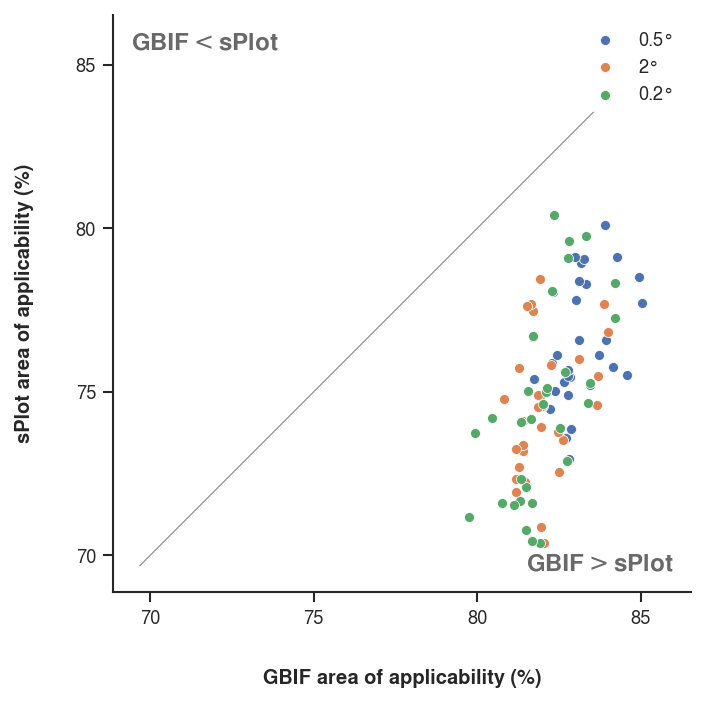

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots()

dfs = [aoa_05, aoa_2, aoa_02]
labels = [
    "0.5°",
    "2°",
    "0.2°",
]

min_val = min([min(*df[["GBIF AOA", "sPlot AOA"]].min()) for df in dfs]) - 1
max_val = max([max(*df[["GBIF AOA", "sPlot AOA"]].max()) for df in dfs]) + 1


for df, label in zip(dfs, labels):
    sns.scatterplot(x=df["GBIF AOA"], y=df["sPlot AOA"], ax=ax, label=label)

label_kwargs = {"weight": "bold", "labelpad": 20}
ax.set_xlabel("GBIF area of applicability (%)", **label_kwargs)
ax.set_ylabel("sPlot area of applicability (%)", **label_kwargs)

line_shift = 0.3
# plot 1-1 line
ax.plot(
    [min_val + line_shift, max_val - line_shift],
    [min_val + line_shift, max_val - line_shift],
    color="grey",
    linestyle="-",
    lw=0.5,
)

text_shift = 0.03

quadrant_label_kwargs = {
    "color": "dimgrey",
    "fontweight": "bold",
    "fontsize": "large",
    "transform": ax.transAxes,
}

ax.text(
    text_shift,
    1 - text_shift,
    horizontalalignment="left",
    verticalalignment="top",
    s="GBIF$<$sPlot",
    **quadrant_label_kwargs,
)

ax.text(
    1 - text_shift,
    text_shift,
    horizontalalignment="right",
    verticalalignment="bottom",
    s="GBIF$>$sPlot",
    **quadrant_label_kwargs,
)

# Ensure yaxis ticks are the same as xaxis ticks
ax.set_yticks([70, 75, 80, 85])

ax.legend(
    loc="upper right", facecolor="white", edgecolor="white", framealpha=1
)  # , bbox_to_anchor=(0.05, 0.85))

sns.set_context("paper", font_scale=1.5)
sns.despine()
ax.set_aspect("equal")
side_size = 5
fig = plt.gcf()
fig.set_figheight(side_size)
fig.set_figwidth(side_size)
fig.set_dpi(150)
plt.savefig(fig_dir / "gbif-vs-splot-aoa.pdf", bbox_inches="tight")

In [17]:
# columns = ["Pct change 2 deg", "Pct change 0.5 deg", "Pct change 0.2 deg", "Pct change 0.01 deg"]
columns = ["Pct change 2 deg", "Pct change 0.5 deg", "Pct change 0.2 deg"]
aoa_all = pd.DataFrame(columns=columns)
aoa_all["Pct change 2 deg"] = aoa_2["Pct change"]
aoa_all["Pct change 0.5 deg"] = aoa_05["Pct change"]
aoa_all["Pct change 0.2 deg"] = aoa_02["Pct change"]
# aoa_all["Pct change 0.01 deg"] = aoa_001["Pct change"]

aoa_all = aoa_all.sort_index()

# add median, mean, and std rows to summarize each column
aoa_all.loc["Median"] = aoa_all.median()
aoa_all.loc["Mean"] = aoa_all.mean()
aoa_all.loc["STD"] = aoa_all.std()

print(aoa_all.round(2).fillna("-").to_markdown())

|                         |   Pct change 2 deg |   Pct change 0.5 deg |   Pct change 0.2 deg |
|:------------------------|-------------------:|---------------------:|---------------------:|
| Chromosome cDNA content |               7.41 |                 7.88 |                 7.49 |
| Chromosome number       |               8.56 |                 7.27 |                 9.58 |
| Conduit element length  |              11.66 |                 9.11 |                 9.67 |
| Dispersal unit length   |               9.05 |                 8.41 |                 8.15 |
| LDMC                    |               9.95 |                 8.25 |                11.55 |
| Leaf C                  |               7.32 |                 4.71 |                 7.03 |
| Leaf C/N ratio          |               7.07 |                 4.26 |                 6.24 |
| Leaf N (area)           |               8.02 |                 7.39 |                 7.37 |
| Leaf N (mass)           |               8.84 |  

In [18]:
# Get the average of all values in aoa_all
aoa_all.median().median()

7.367509983233866

## Global trait maps visualization

Figure of global trait maps for selected traits with two columns—left column containing trait predictions masked by AoA, right column containing trait prediction CoV (also masked by AoA?)

First, back-transform trait values predicted by models trained in log-space.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


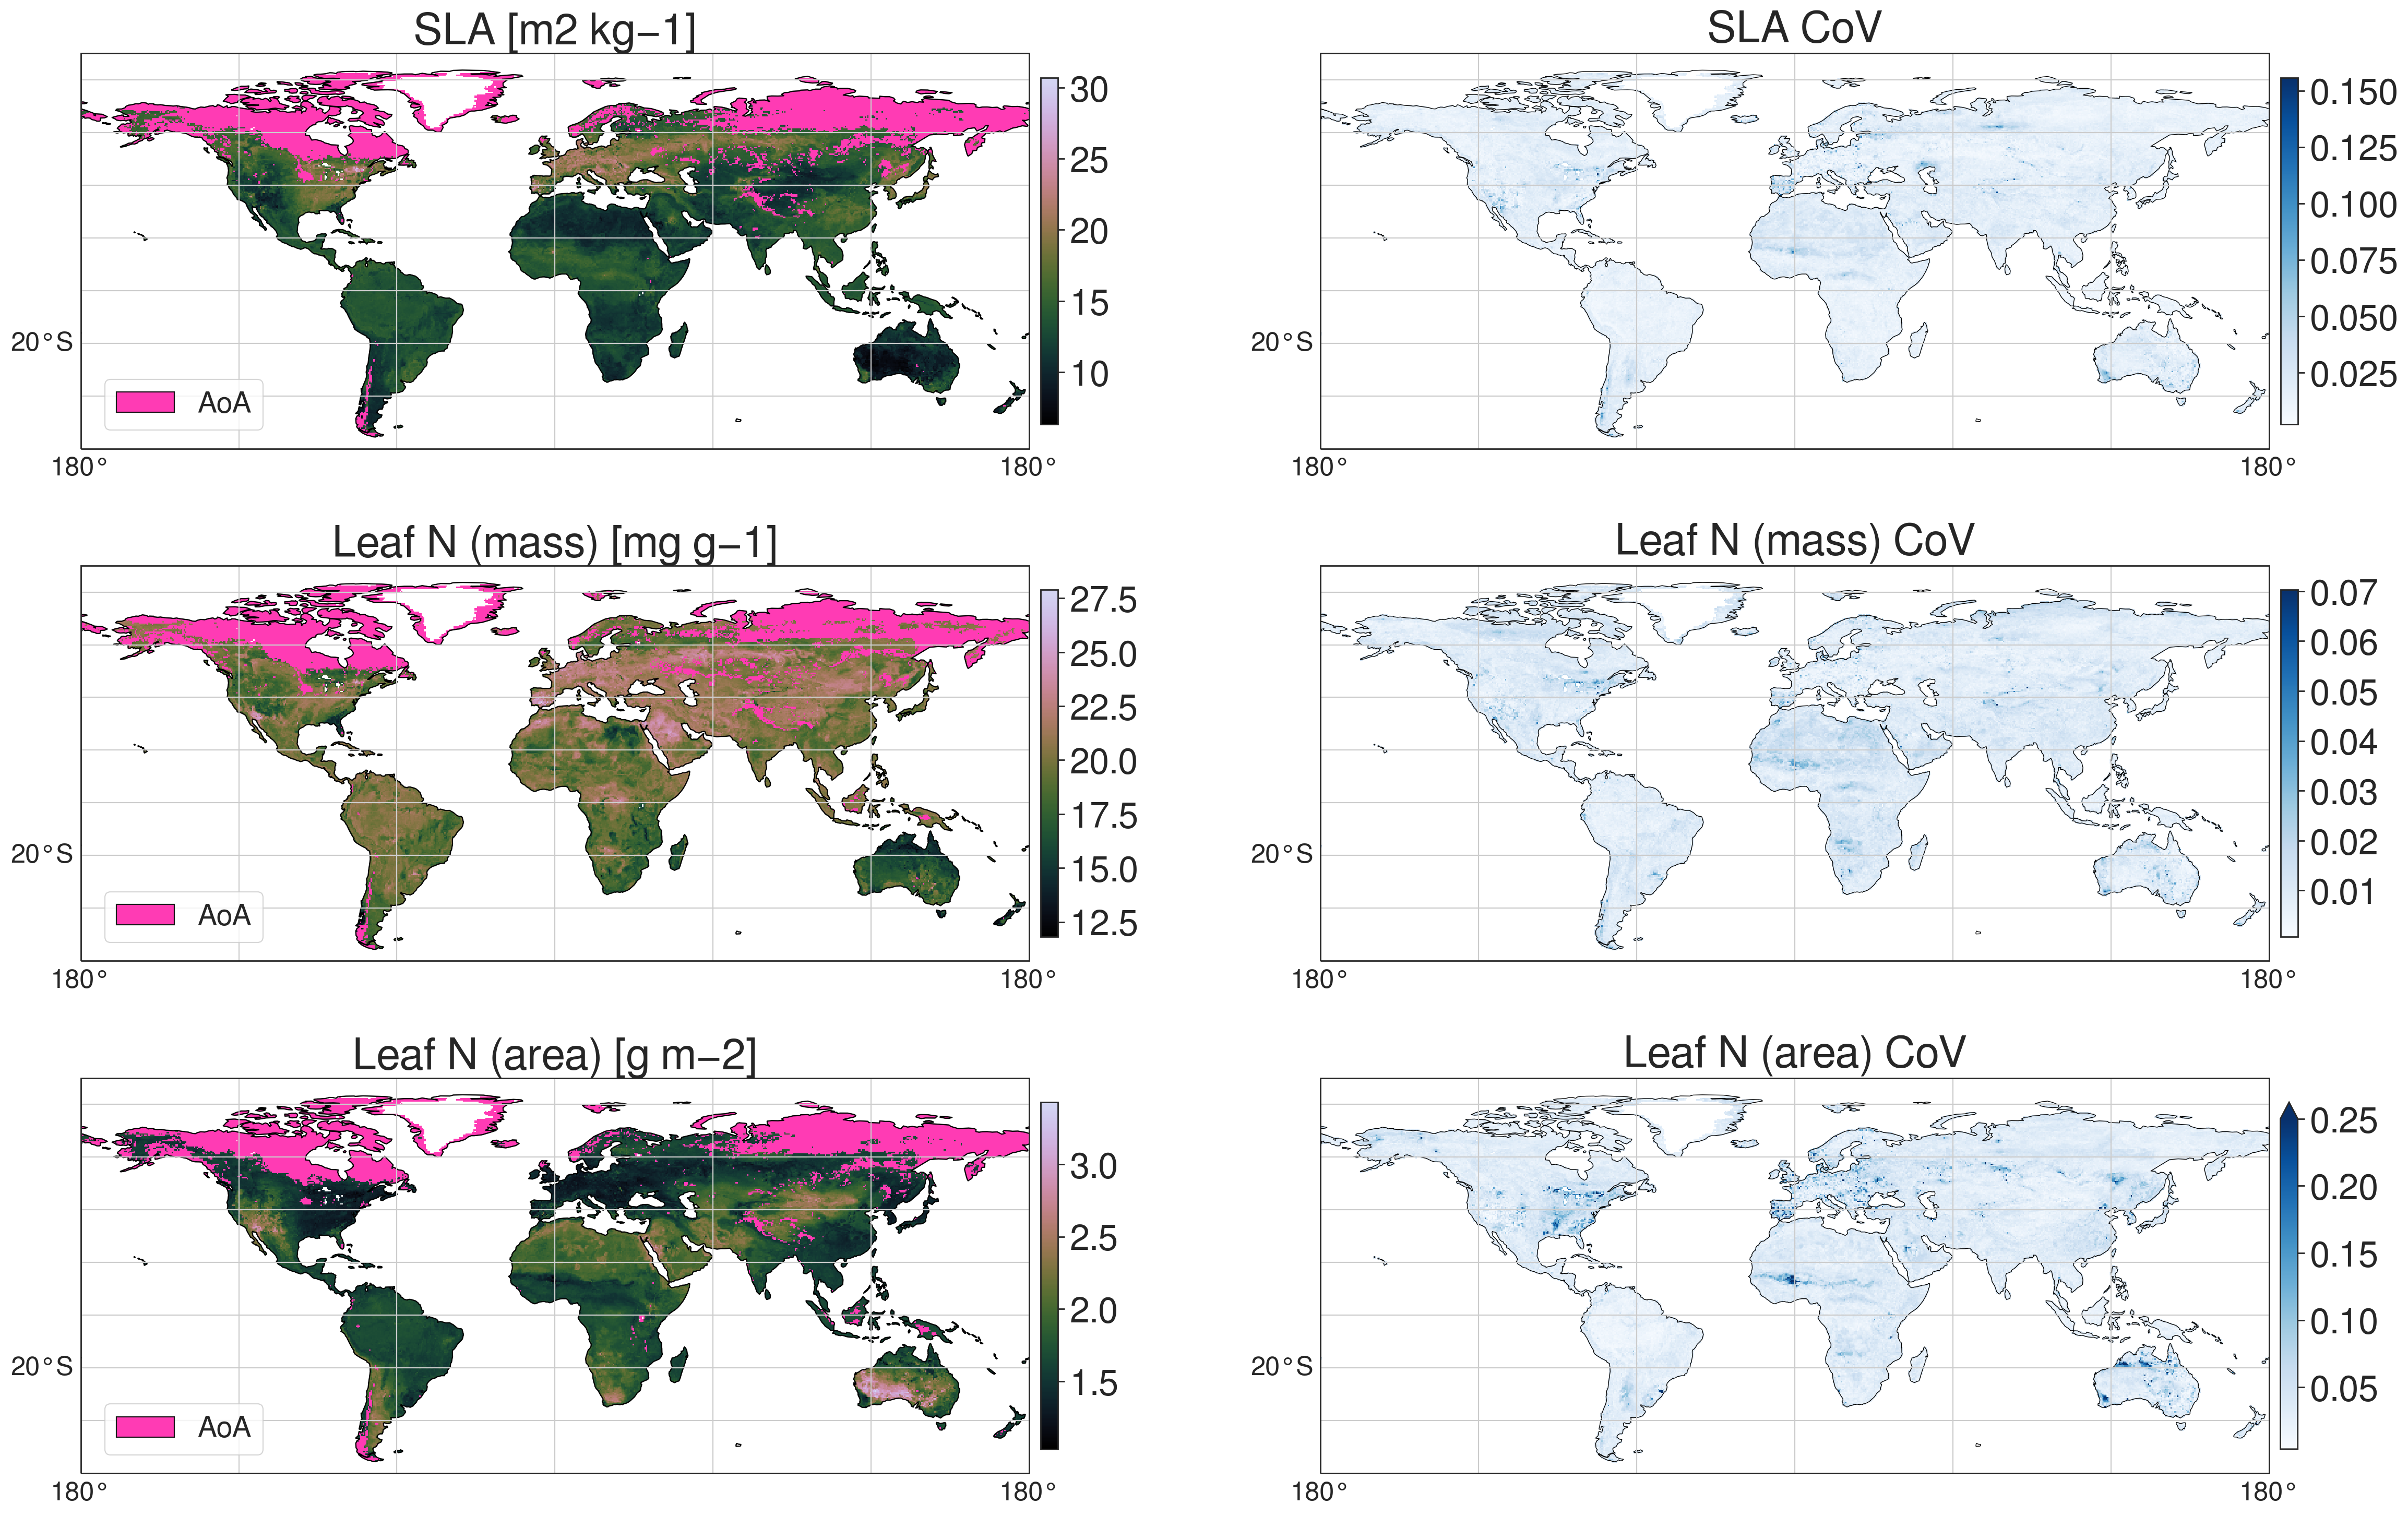

In [78]:
from pathlib import Path

import rioxarray as riox
from utils.geodata import get_trait_id_from_data_name, num_to_str
from utils.visualize import plot_pred_cov

trait_idx = [11, 50, 14]
resolution = 0.5

fns = [
    p
    for p in Path(
        f"maps/Shrub_Tree_Grass/05deg_models/{num_to_str(resolution)}deg"
    ).glob("sPlot*")
    if int(get_trait_id_from_data_name(p.name)) in trait_idx
]

# fns = list(
#     Path(f"maps/Shrub_Tree_Grass/05deg_models/{num_to_str(resolution)}deg").glob(
#         "GBIF*"
#     )
# )

gbif_maps = [riox.open_rasterio(fn, mask_and_scale=True) for fn in sorted(fns)]

plot_pred_cov(
    gbif_maps,
    font_scale=2.8,
    # out_fn=f"reports/figures/select-trait-maps-{num_to_str(resolution)}deg.png",
    show=True,
    aoa=True
)

Figure (appendix): All remaining global trait maps with > R2-THRESHOLD

## Feature importances

Filter models with a CV r^2 below 0.2

In [15]:
pi_gbif = PI.loc[best_models_gbif[best_models_gbif["CV r-squared"] > 0.2].index]
pi_splot = PI.loc[best_models_splot[best_models_splot["CV r-squared"] > 0.2].index]

In [16]:
def ds_importance(PIs):
    PIs = ast.literal_eval(PIs)

    ds_keys = {
        "MODIS": ["sur_refl"],
        "WorldClim": ["wc2.1"],
        "Soil": [
            "0-5cm",
            "0-30cm",
            "5-15cm",
            "15-30cm",
            "30-60cm",
            "60-100cm",
            "100-200cm",
        ],
        "VODCA": ["C_2", "Ku_2", "X_2"],
    }

    # Get the average and standard deviation of the predictor importance values for each dataset
    PIs = {k: [np.mean(v), np.std(v)] for k, v in PIs.items()}

    ds_importance = {}

    for ds, keys in ds_keys.items():
        for feature, imp in PIs.items():
            for key in keys:
                if key in feature:
                    if ds not in ds_importance:
                        ds_importance[ds] = []
                    ds_importance[ds].append(imp)

    return ds_importance

In [17]:
# Get DS importance for each response variable in PI_orig_gbif and PI_orig_splot
pi_gbif["DS importance"] = pi_gbif["CV predictor importance"].apply(ds_importance)
pi_splot["DS importance"] = pi_splot["CV predictor importance"].apply(ds_importance)

Figure: box and whisker plot of predictor datasets (x-axis) and their average importances across all traits for which models had a > R2-THRESHOLD score.

In [18]:
def plot_feature_importances(importances_df, out_fn=None):

    fig, ax = plt.subplots(1)

    label_kwargs = {
        "fontweight": "bold",
        # "fontsize": 11,
        "labelpad": 15
    }

    sns.boxplot(x="Dataset", y="Mean importance", data=importances_df, ax=ax)
    ax.set_xlabel("Dataset", **label_kwargs)
    ax.set_ylabel("Mean importance", **label_kwargs)

    # Reduce the space in between the axes
    plt.subplots_adjust(wspace=0.05)
    fig = plt.gcf()

    figheight = 8
    fig.set_figheight(figheight)

    plt.gca().set_aspect(110)
    sns.despine()
    sns.set_context("paper", font_scale=1.9)

    if out_fn is not None:
        plt.savefig(out_fn, bbox_inches="tight")

In [19]:
# create a list of dataframes for each dataset for GBIF
dfs_gbif = []
for ds in pi_gbif["DS importance"].iloc[0].keys():
    df = pd.DataFrame(
        {
            "Dataset": ds,
            "Mean importance": [
                np.asarray(imp[ds])[:, 0].mean() for imp in pi_gbif["DS importance"]
            ],
            "STD importance": [
                np.asarray(imp[ds])[:, 1].mean() for imp in pi_gbif["DS importance"]
            ],
        }
    )
    dfs_gbif.append(df)

# concatenate the dataframes into a single dataframe for GBIF
df_gbif = pd.concat(dfs_gbif)

# create a list of dataframes for each dataset for sPlot
dfs_splot = []
for ds in pi_splot["DS importance"].iloc[0].keys():
    df = pd.DataFrame(
        {
            "Dataset": ds,
            "Mean importance": [
                np.asarray(imp[ds])[:, 0].mean() for imp in pi_splot["DS importance"]
            ],
            "STD importance": [
                np.asarray(imp[ds])[:, 1].mean() for imp in pi_splot["DS importance"]
            ],
        }
    )
    dfs_splot.append(df)

# concatenate the dataframes into a single dataframe for sPlot
df_splot = pd.concat(dfs_splot)

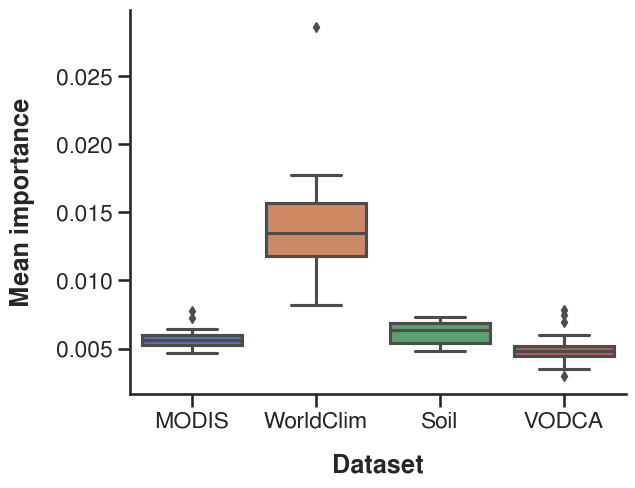

In [20]:
# plot_feature_importances(df_gbif, out_fn="reports/figures/gbif-ds-importances.pdf")
plot_feature_importances(df_gbif)

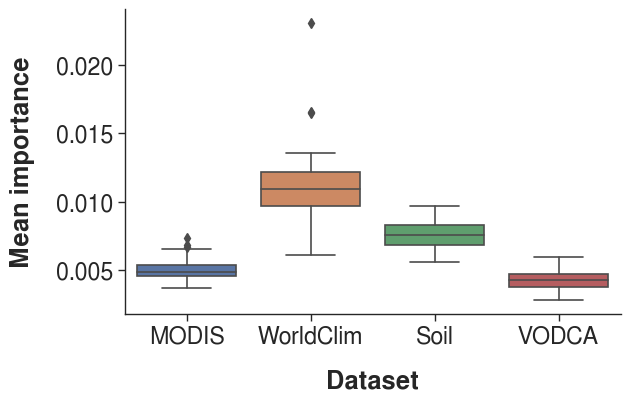

In [26]:
plot_feature_importances(df_splot, out_fn="reports/figures/splot-ds-importances.pdf")

Figure (appendix): Feature importance of individual predictors across all traits for which models had a > R2-THRESHOLD score.

## Comparison of GBIF (and other products) with sPlotOpen grids

Build the dataframe

In [27]:
import json
from pathlib import Path

import pandas as pd
from utils.geodata import open_raster

prod_02_fns = Path(
    "data/other-products/all-prods_stacks_sla-nit-nita_02D_2023-12-15"
).glob("*.nc")
prod_05_fns = Path(
    "data/other-products/all-prods_stacks_sla-nit-nita_05D_2023-12-15"
).glob("*.nc")
prod_2_fns = Path(
    "data/other-products/all-prods_stacks_sla-nit-nita_2D_2023-12-15"
).glob("*.nc")

# Rioxarray opens single-var netCDFs as DataArrays, so we need to convert them to Datasets
prod_02_deg = [
    open_raster(fn, masked=True).to_dataset(name="Wolf") for fn in prod_02_fns
]
prod_05_deg = [open_raster(fn, masked=True) for fn in prod_05_fns]
prod_2_deg = [open_raster(fn, masked=True) for fn in prod_2_fns]

trait_product_mapping = {
    50: "_nita_",
    14: "_nit_",
    11: "_sla_",
}

product_names = sorted(set([str(dv) for prod in prod_05_deg for dv in prod.data_vars]))

with open("./trait_mapping.json", "r", encoding="utf-8") as f:
    trait_mapping = json.load(f)

traits = [
    trait_mapping[str(trait_id)]["short"] for trait_id in trait_product_mapping.keys()
]

mi_columns = pd.MultiIndex.from_product(
    [traits, ["2", "0.5", "0.2", "0.01"]], names=["Trait", "Resolution"]
)

rows = pd.Index(product_names, name="Product")
product_df = pd.DataFrame(index=rows, columns=mi_columns)

In [28]:
from utils.geodata import ds2gdf, open_raster, num_to_str
from utils.spatial_stats import compare_gdfs

resolutions = ["2", "0.5", "0.2"]

for res in resolutions:
    if res == "2":
        prod_set = prod_2_deg
    elif res == "0.5":
        prod_set = prod_05_deg
    elif res == "0.2":
        prod_set = prod_02_deg

    for i, trait in enumerate(prod_set):
        dv_names = list(trait.data_vars)
        prod_fn = trait[dv_names[0]].encoding["source"]
        for k, v in trait_product_mapping.items():
            if v in prod_fn:
                trait_id = k
                break
        trait_name = trait_mapping[str(trait_id)]["short"]
        # print(trait_name)
        splot = open_raster(
            list(
                Path(
                    "GBIF_trait_maps/global_maps/Shrub_Tree_Grass",
                    f"{num_to_str(float(res))}deg",
                ).glob(f"sPlot*_X{trait_id}_*.grd")
            )[0],
            masked=True,
        ).sel(band=2)
        splot = ds2gdf(splot, f"splot {trait_name}")

        for prod in trait.data_vars:
            gdf = ds2gdf(trait[prod], trait_name)
            corr = compare_gdfs(gdf, splot)
            # print(f"{res}: {corr}")
            product_df.loc[prod, (trait_name, res)] = corr

product_df = product_df.astype(float)
product_df.round(3)

2024-01-06 16:05:26.726373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 16:05:27.309561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trait      Leaf N (area)                    Leaf N (mass)                     \
Resolution             2    0.5    0.2 0.01             2    0.5    0.2 0.01   
Product                                                                        
Bodegom              NaN    NaN    NaN  NaN           NaN    NaN    NaN  NaN   
Boonman            0.541  0.481    NaN  NaN         0.060  0.013    NaN  NaN   
Butler             0.467  0.465    NaN  NaN         0.153  0.174    NaN  NaN   
Dong               0.493  0.562    NaN  NaN         0.186  0.161    NaN  NaN   
Madani               NaN    NaN    NaN  NaN           NaN    NaN    NaN  NaN   
Moreno             0.585  0.520    NaN  NaN         0.149  0.200    NaN  NaN   
Schiller           0.690  0.588    NaN  NaN         0.436  0.439    NaN  NaN   
Vallicrosa        -0.006  0.010    NaN  NaN         0.149  0.223    NaN  NaN   
Wolf               0.567  0.561  0.504  NaN         0.354  0.398  0.344  NaN   

Trait         SLA                    
Resolution      2    0.5   0.2 0.01  
Product                              
Bodegom     0.441  0.451   NaN  NaN  
Boonman     0.458  0.504   NaN  NaN  
Butler      0.226  0.266   NaN  NaN  
Dong        0.320  0.345   NaN  NaN  
Madani      0.161  0.009   NaN  NaN  
Moreno      0.435  0.433   NaN  NaN  
Schiller    0.612  0.599   NaN  NaN  
Vallicrosa    NaN    NaN   NaN  NaN  
Wolf        0.538  0.581  0.55  NaN

#### Now load GBIF and sPlot correlations

See `scripts/splot_correlations.py`

In [21]:
import pandas as pd

%load_ext autoreload
%autoreload 2

corr_table = pd.read_parquet("results/weighted_correlations.parquet")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
corr_table

Resolution                     2                 0.5                 0.2  \
Training data               GBIF     sPlot      GBIF     sPlot      GBIF   
Trait PFT                                                                  
X4    Grass             0.581744  0.752511  0.589704  0.920804  0.396660   
      Shrub-Tree        0.669287  0.871791  0.632475  0.956329  0.578312   
      Shrub-Tree-Grass  0.651105  0.854923  0.674028  0.970044  0.607986   
X6    Grass             0.461884  0.691075  0.538122  0.905054  0.236605   
      Shrub-Tree        0.676712  0.835771  0.704965  0.942813  0.517947   
...                          ...       ...       ...       ...       ...   
X3114 Shrub-Tree        0.779139  0.853419  0.671684  0.911523  0.721412   
      Shrub-Tree-Grass  0.703000  0.824142  0.610165  0.897036  0.688415   
X3120 Grass             0.491484  0.716134  0.551799  0.898065  0.448867   
      Shrub-Tree        0.405353  0.711008  0.392611  0.911089  0.252588   
      Shrub-Tree-Grass  0.498467  0.754595  0.538990  0.930638  0.348472   

Resolution                            0.01            
Training data              sPlot      GBIF     sPlot  
Trait PFT                                             
X4    Grass             0.562191  0.433440  0.516861  
      Shrub-Tree        0.754130  0.602309  0.749729  
      Shrub-Tree-Grass  0.722225  0.614639  0.696924  
X6    Grass             0.344972  0.104339  0.153431  
      Shrub-Tree        0.586419  0.279245  0.306020  
...                          ...       ...       ...  
X3114 Shrub-Tree        0.812801  0.561945  0.664685  
      Shrub-Tree-Grass  0.800615  0.532330  0.646143  
X3120 Grass             0.643688  0.475529  0.569251  
      Shrub-Tree        0.510150  0.139406  0.222810  
      Shrub-Tree-Grass  0.651940  0.247105  0.346726  

[99 rows x 8 columns]

Get only Shrub-Tree-Grass correlations for selected traits

In [23]:
idx = pd.IndexSlice
gbif_splot_corr = corr_table.loc[
    idx[
        [f"X{trait_id}" for trait_id in trait_product_mapping.keys()],
        "Shrub-Tree-Grass",
    ],
    :,
]
gbif_splot_corr.index = gbif_splot_corr.index.droplevel(1)
gbif_splot_corr

NameError: name 'trait_product_mapping' is not defined

In [32]:
for row in gbif_splot_corr.iterrows():
    trait_id = row[0].split("X")[-1]
    trait_name = trait_mapping[trait_id]["short"]
    sub_df = row[1].reset_index()
    for sub_row in sub_df.iterrows():
        res = sub_row[1]["Resolution"]
        train_set = sub_row[1]["Training data"]
        corr = sub_row[1][-1]
        product_df.loc[train_set, (trait_name, res)] = corr

In [33]:
product_df.sort_values(by=[("Leaf N (mass)", "0.5")], ascending=False).astype(float).round(
    2
).fillna("-")

Trait      Leaf N (area)                   Leaf N (mass)                    \
Resolution             2   0.5   0.2  0.01             2   0.5   0.2  0.01   
Product                                                                      
sPlot               0.85  0.96  0.74  0.59          0.75  0.94  0.64  0.49   
GBIF                0.65  0.66  0.62   0.5          0.48  0.54  0.39  0.35   
Schiller            0.69  0.59     -     -          0.44  0.44     -     -   
Wolf                0.57  0.56   0.5     -          0.35   0.4  0.34     -   
Vallicrosa         -0.01  0.01     -     -          0.15  0.22     -     -   
Moreno              0.59  0.52     -     -          0.15   0.2     -     -   
Butler              0.47  0.47     -     -          0.15  0.17     -     -   
Dong                0.49  0.56     -     -          0.19  0.16     -     -   
Boonman             0.54  0.48     -     -          0.06  0.01     -     -   
Bodegom                -     -     -     -             -     -     -     -   
Madani                 -     -     -     -             -     -     -     -   

Trait        SLA                    
Resolution     2   0.5   0.2  0.01  
Product                             
sPlot        0.8  0.96  0.66  0.55  
GBIF         0.6  0.67  0.46  0.42  
Schiller    0.61   0.6     -     -  
Wolf        0.54  0.58  0.55     -  
Vallicrosa     -     -     -     -  
Moreno      0.44  0.43     -     -  
Butler      0.23  0.27     -     -  
Dong        0.32  0.34     -     -  
Boonman     0.46   0.5     -     -  
Bodegom     0.44  0.45     -     -  
Madani      0.16  0.01     -     -

#### Shrub-Tree-Grass

Scatter plot

In [ ]:
from typing import Any
from adjustText import adjust_text


def plot_splot_correlations(df: pd.DataFrame, pft: str, trait_set: str = "GBIF", context: Any = "paper", font_scale: float = 1, save: bool = False):
    """Plot sPlot correlations for GBIF and sPlot extrapolations for the given PFT"""
    idx = pd.IndexSlice
    df = df.loc[idx[:, pft], idx[:, trait_set]]

    # Hide the PFT index
    df.index = df.index.droplevel(1)

    with sns.plotting_context(context, font_scale):
        # fig, axs = plt.subplots(1, 2, figsize=(20, 25), dpi=150)
        fig, ax = plt.subplots(1, dpi=200)

        df = df.sort_index(ascending=False)
        text_x = 0.98

        # Define colors
        # colors = plt.cm.Paired(np.linspace(0, 1, len(stg.index.get_level_values(0).unique())))
        # use sns instead (e.g. sns.hls_palette(h=.5))
        colors = sns.color_palette(n_colors=len(df.index.get_level_values(0).unique()))

        # context
        sns.set_context(context, font_scale=font_scale)

        with open("trait_mapping.json", "r", encoding="utf-8") as f:
            trait_mapping = json.load(f)

        x_positions = [text_x] * len(df.index.get_level_values(0).unique())

        y_positions = []

        labels = []
        label_colors = []

        label_kwargs = {
            "fontweight": "bold",
            # "fontsize": 11,
            "labelpad": 20
        }

        # Loop over each trait
        for color, trait in zip(colors, df.index.get_level_values(0).unique()):
            # Select data for the current trait
            trait_data = df.loc[trait]

            trait_short = trait_mapping[trait.split("X")[-1]]["short"]

            data = trait_data.xs(trait_set, axis=0, level=1)
            y_positions.append(data.iloc[0])
            
            labels.append(trait_short)
            label_colors.append(color)

            ax_params = {
                "linestyle": "-",
                "color": color,
                "marker": "o",
                "markeredgecolor": "white",
                "markeredgewidth": 1.0
            }

            ax.plot(
                data,
                **ax_params
            )
            ax.set_ylabel("$r$", **label_kwargs)

        texts = []
        for x_position, y_position, label, color in zip(
            x_positions, y_positions, labels, label_colors
        ):
            text = ax.text(
                x_position,
                y_position,
                label,
                color=color,
                fontsize="small"
            )
            texts.append(text)

        adjust_text_kwargs = {
            "autoalign": "y",
            # "expand_text": (1, 1.5),
            "only_move": {"text": "y", "static": "y", "explode": "y", "pull": "y"},
            "text_from_points": False,
            "precision": 0.01
        }


        ax.set_xlabel("Resolution ($\degree$)", **label_kwargs)
        ax.invert_xaxis()

        # Show the plots
        sns.despine()

        # add space between plots
        # plt.subplots_adjust(wspace=0.8)

        fig.set_figheight(14)
        # ax.set_aspect(20)
        
        adjust_text(
            texts,
            ax=ax,
            force_text=(0, 1.5),
            **adjust_text_kwargs,
        )

        # Readjust the x-position of the text since adjust_text doesn't seem to respect the
        # only_move parameter and still moves the text in the x-direction
        def _reset_text_x(texts, x_position, ax):
            for text in texts:
                text.set_ha("left")
                text.set_x(x_position)
                text.set_transform(ax.get_yaxis_transform())

        _reset_text_x(texts, text_x, ax)

        if save:
            plt.savefig(fig_dir / f"{trait_set.lower()}-splot-corr.pdf", bbox_inches="tight")
    
    plt.show()

# Drop rows where the index Trait is equal to X3112 or X3114
idx = pd.IndexSlice
filt_corr = corr_table.loc[
    idx[
        [f"X{trait_id}" for trait_id in mapping.keys() if int(trait_id) not in excluded_tidx],
        :,
    ],
    :,
]

plot_splot_correlations(filt_corr, "Shrub-Tree-Grass", context="paper",font_scale=1.3, save=True)

In [ ]:
plot_splot_correlations(filt_corr, "Shrub-Tree-Grass", trait_set="sPlot", context="paper",font_scale=1.3, save=True)

Violin plot

In [34]:
# Drop rows where the index Trait is equal to X3112 or X3114
idx = pd.IndexSlice
pft = "Shrub-Tree-Grass"
trait_set = "GBIF"

filt_corr = corr_table.loc[
    idx[
        [f"X{trait_id}" for trait_id in mapping.keys() if int(trait_id) not in excluded_tidx],
        :,
    ],
    :,
]
filt_corr = filt_corr.loc[idx[:, pft], idx[:, trait_set]]

# Hide the PFT index
filt_corr.index = filt_corr.index.droplevel(1)

# Hide the GBIF column identifier
filt_corr.columns = filt_corr.columns.droplevel(1)

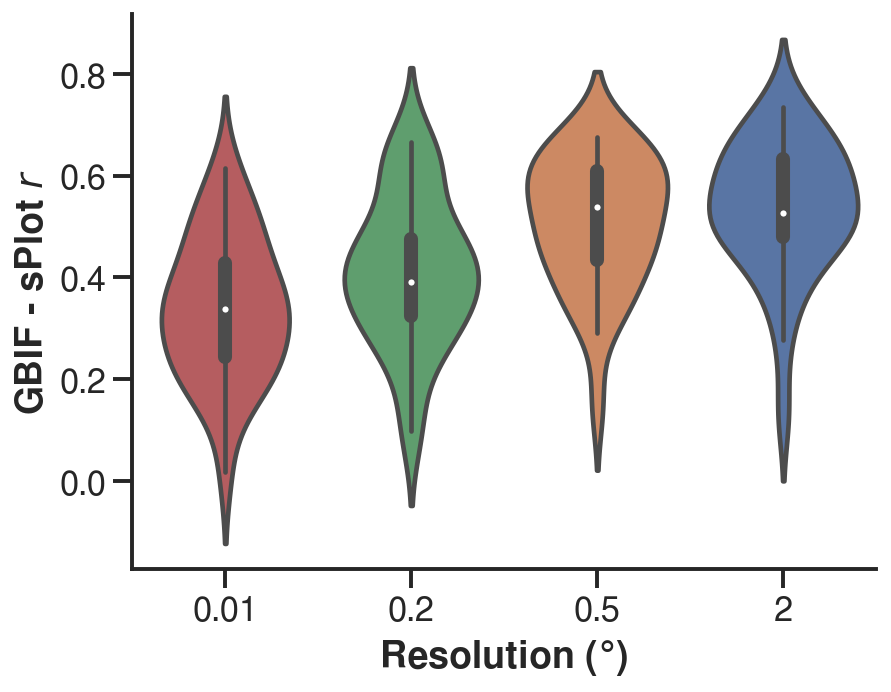

In [74]:
with sns.plotting_context("talk"):
    ax = sns.violinplot(filt_corr, inner="box")
    ax.set_ylabel("GBIF - sPlot $r$", fontweight="bold")
    ax.set_xlabel("Resolution ($\degree$)", fontweight="bold")
    ax.invert_xaxis()
    fig = plt.gcf()
    fig.set_dpi(150)
    sns.despine()


Table

In [53]:
import json


corr_stg = filt_corr.copy().loc[pd.IndexSlice[:, "Shrub-Tree-Grass"], :]

with open("trait_mapping.json", "r") as f:
    trait_mapping = json.load(f)

# Add trait name column to corr_table
corr_stg["Trait name"] = corr_stg.index.map(
    lambda x: trait_mapping[x[0].split("X")[1]]["short"]
)
corr_stg = corr_stg.set_index("Trait name", append=True).droplevel(1)
corr_stg.index = corr_stg.index.droplevel(0)

corr_stg = corr_stg.sort_values(by=["Trait name"], ascending=True).round(2)
# Color cells in each column according to their value
corr_stg.style.background_gradient(cmap="coolwarm", axis=0)



# Bold the highest value in each column
# corr_stg.style.highlight_max(axis=0)

# corr_stg.loc[["2", "0.5", "0.2", "0.01"]]

# corr_stg.to_markdown()
# corr_stg

SyntaxError: invalid syntax (2969497996.py, line 25)

In [70]:
corr_stg.loc[:, idx[:, "GBIF"]].sort_values(
    by=[("0.5", "GBIF"), ("0.2", "GBIF"), ("0.01", "GBIF")],
    ascending=False,
).style.background_gradient(cmap="coolwarm", axis=0)